# Sea ice thickness comparisons: 

In [1]:
import sys
import numpy as np
import xarray as xr
import datetime
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy.crs as ccrs
import pandas as pd

import pickle 

In [2]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)

In [3]:
sys.path.append("/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/")

import LIM_utils_kb as limkb
#import LIM_stats_kb as statskb
# import LIM_plot_kb as plotkb
import LIM_building as limbuild

In [4]:
sys.path.append("../../")
import Online_DA_utils as oda

In [5]:
plt.rcParams['figure.dpi']=300

In [6]:
limname = 'cesm_lme_Amon'

LIM = oda.load_L(limname)
LIMd = LIM['LIMd']
LIMd.keys()

Loading: /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/master/LIMcast_cesm_lme_Amon_ntrain_850_1650_cesm_lme_Amon_validy_1651_1850_tas50L0.1_psl50L0.1_zg50L0.1_tos50L0.1_sit50L40_sic50L40_20211202_sqrtWt.pkl


dict_keys(['vec', 'veci', 'val', 'lam_L', 'C_0', 'C_1', 'Gt', 'lam_L_adj', 'npos_eigenvalues', 'E3', 'W_all', 'standard_factor', 'E3_all', 'E_sic', 'var_dict', 'P_train', 'exp_setup', 'frac_neg_eigenvals'])

In [7]:
nyears = 170
#nyears = 155

# Generate times: 
t_total = nyears*12
years = int(1851+np.floor((t_total-1)/12))
time = np.array([datetime.datetime(y, m, 15) for y in np.arange(1851,1851+nyears,1) for m in np.arange(1,13,1)])

In [8]:
niters = 20
it_list = np.arange(1,niters+1,1)

limvars = ['tas','tos','psl','zg','sit','sic']

In [9]:
def calc_tot_sivol_checks(sit, areacell, units, lat, nlon, lat_cutoff=0.0): 
    """Calculates total NH sea ice volume. 
    
    INPUTS: 
    var: sea ice thickness (ndof,ntime), units = 'sivol per unit grid cell area', [ndarray]
    areacell: grid cell area, 1D or 2D, [ndarray]
    units: string ('km^2' or 'm2')
    lat: 
    lat_cutoff
    
    OUTPUTS: 
    tot_nh_vol
    """
    
    if len(areacell.shape)>1:
        areacell_1d = np.reshape(areacell,(areacell.shape[0]*areacell.shape[1]))
    else: 
        areacell_1d = areacell

    if units == 'm2':
        print('changing units of cell area from '+units+' to km^2')
        cellarea = (areacell_1d*1e-6)[:,np.newaxis]
    else: 
        print('not changing units of cell area')
        cellarea = areacell_1d[:,np.newaxis]

    if len(sit.shape)<=1:
        sit_3d = np.reshape(sit,(lat.shape[0],nlon))
    elif len(sit.shape) ==2:     
        sit_3d = np.reshape(sit,(lat.shape[0],nlon,sit.shape[1]))
    else: 
        sit_3d = sit

    if len(lat.shape)<=1:
        sit_nh_3d = sit_3d[(lat>0),:,:]
        test_sit = sit_nh_3d[np.isfinite(sit_nh_3d)]
    elif len(lat.shape)>1:
        sit_nh_3d = sit_3d[(lat>0),:]
        test_sit = sit_nh_3d[np.isfinite(sit_nh_3d)]

    nh_vol = sit*cellarea

    if len(lat.shape)<=1:
        if len(sit.shape)<=1:
            nh_vol_3d = np.reshape(nh_vol,(lat.shape[0],nlon))
            lat_inds = np.where(lat>lat_cutoff)
            tot_nh_vol = np.nansum(np.nansum(nh_vol_3d[lat_inds,:].squeeze(),axis=0),axis=0)
        else:     
            nh_vol_3d = np.reshape(nh_vol,(lat.shape[0],nlon,sit.shape[1]))
            lat_inds = np.where(lat>lat_cutoff)
            tot_nh_vol = np.nansum(np.nansum(nh_vol_3d[lat_inds,:,:].squeeze(),axis=0),axis=0)
    else:
        lat_1d = np.reshape(lat,(sit.shape[0]))
        lat_inds = np.where(lat_1d>lat_cutoff)
        tot_nh_vol = np.nansum(nh_vol[lat_inds,:].squeeze(),axis=0)
        
    return tot_nh_vol

## Load reconstructions: 

In [10]:
output_dir = '/home/disk/kalman2/mkb22/Online_DA/experiments/hadcrut/nobs50/'
data_all = {}

#Xa_dcomp = np.zeros((niters,LIMd['E3_all'].shape[0]+LIMd['E_sic'].shape[0],data['Xa'].shape[0]))
nmodes = LIMd['E3_all'].shape[1]

for i,it in enumerate(it_list):
    print('working on iteration '+str(it))
#     filename = ('ODA_prior_cesm_lme_Amon_LIM_cesm_lme_Amon_obs_hadCRUT_all_rand50_t_0_2040'+
#                 '_nomj_trainR_it'+str(it)+'.pkl')
#     filename = ('ODA_prior_cesm_lme_Amon_LIM_cesm_lme_Amon_obs_hadCRUT_all_rand100_t_0_2040'+
#                 '_nomj_trainR1_it'+str(it)+'_test.pkl')
    filename = ('ODA_prior_cesm_lme_Amon_LIM_cesm_lme_Amon_obs_hadCRUT_all_rand100_t_0_2040'+
                '_nomj_trainR1_it'+str(it)+'.pkl')
#     filename = ('ODA_prior_cesm_lme_Amon_LIM_cesm_lme_Amon_obs_cmip6_mpi_hist_regridlme_Amon_'+
#                 'rand50_t_0_1860_nomj_trainRe_it'+str(it)+'_test.pkl')

    data_all[it] = pickle.load(open(output_dir+filename,"rb"))
    
    if i is 0: 
        Xa_dcomp = np.zeros((niters,LIMd['E3_all'].shape[0]+LIMd['E_sic'].shape[0],data_all[it]['Xa'].shape[0]))
        Pb_diag_dcomp = np.zeros((niters,LIMd['E3_all'].shape[0]+LIMd['E_sic'].shape[0],data_all[it]['Xa'].shape[0]))

    Xa_dcomp[i,:,:] = limkb.decompress_eof_separate_sic(data_all[it]['Xa'].T,nmodes,LIMd['exp_setup']['nmodes_sic'],
                                                         LIMd['E3_all'],LIMd['E_sic'],LIMd['exp_setup']['limvars'],
                                                         LIMd['var_dict'],LIMd['W_all'],Weights=LIMd['exp_setup']['Weight'],
                                                         sic_separate=LIMd['exp_setup']['sic_separate'])
    Pb_diag_dcomp[i,:,:] = limkb.decompress_eof_separate_sic(data_all[it]['Pb_diagonal'].T,nmodes,
                                                             LIMd['exp_setup']['nmodes_sic'],
                                                             LIMd['E3_all'],LIMd['E_sic'],
                                                             LIMd['exp_setup']['limvars'],
                                                             LIMd['var_dict'],LIMd['W_all'],
                                                             Weights=LIMd['exp_setup']['Weight'],
                                                             sic_separate=LIMd['exp_setup']['sic_separate'])

working on iteration 1
working on iteration 2
working on iteration 3
working on iteration 4
working on iteration 5
working on iteration 6
working on iteration 7
working on iteration 8
working on iteration 9
working on iteration 10
working on iteration 11
working on iteration 12
working on iteration 13
working on iteration 14
working on iteration 15
working on iteration 16
working on iteration 17
working on iteration 18
working on iteration 19
working on iteration 20


In [11]:
Xa_dcomp_all = {}
Pb_diag_dcomp_all = {}

for var in limvars: 
    print('working on '+var)
    Pb_diag_dcomp_var = np.zeros((niters, LIMd['var_dict'][var]['var_ndof'],data_all[1]['Xa'].shape[0]))
    Xa_dcomp_var = np.zeros((niters, LIMd['var_dict'][var]['var_ndof'],data_all[1]['Xa'].shape[0]))
    for i,it in enumerate(it_list):
        Xa_dcomp_var[i,:,:] = Xa_dcomp[i,LIMd['var_dict'][var]['var_inds'],:]
        Pb_diag_dcomp_var[i,:,:] = Xa_dcomp[i,LIMd['var_dict'][var]['var_inds'],:]
        
#     if 'sic' in var:
#         Xa_dcomp_var = np.where(Xa_dcomp_var>1,1,Xa_dcomp_var)
#         Xa_dcomp_var = np.where(Xa_dcomp_var<-1,-1,Xa_dcomp_var)

    Xa_dcomp_all[var] = Xa_dcomp_var
    Pb_diag_dcomp_all[var] = Pb_diag_dcomp_var

working on tas
working on tos
working on psl
working on zg
working on sit
working on sic


(-10, 10)

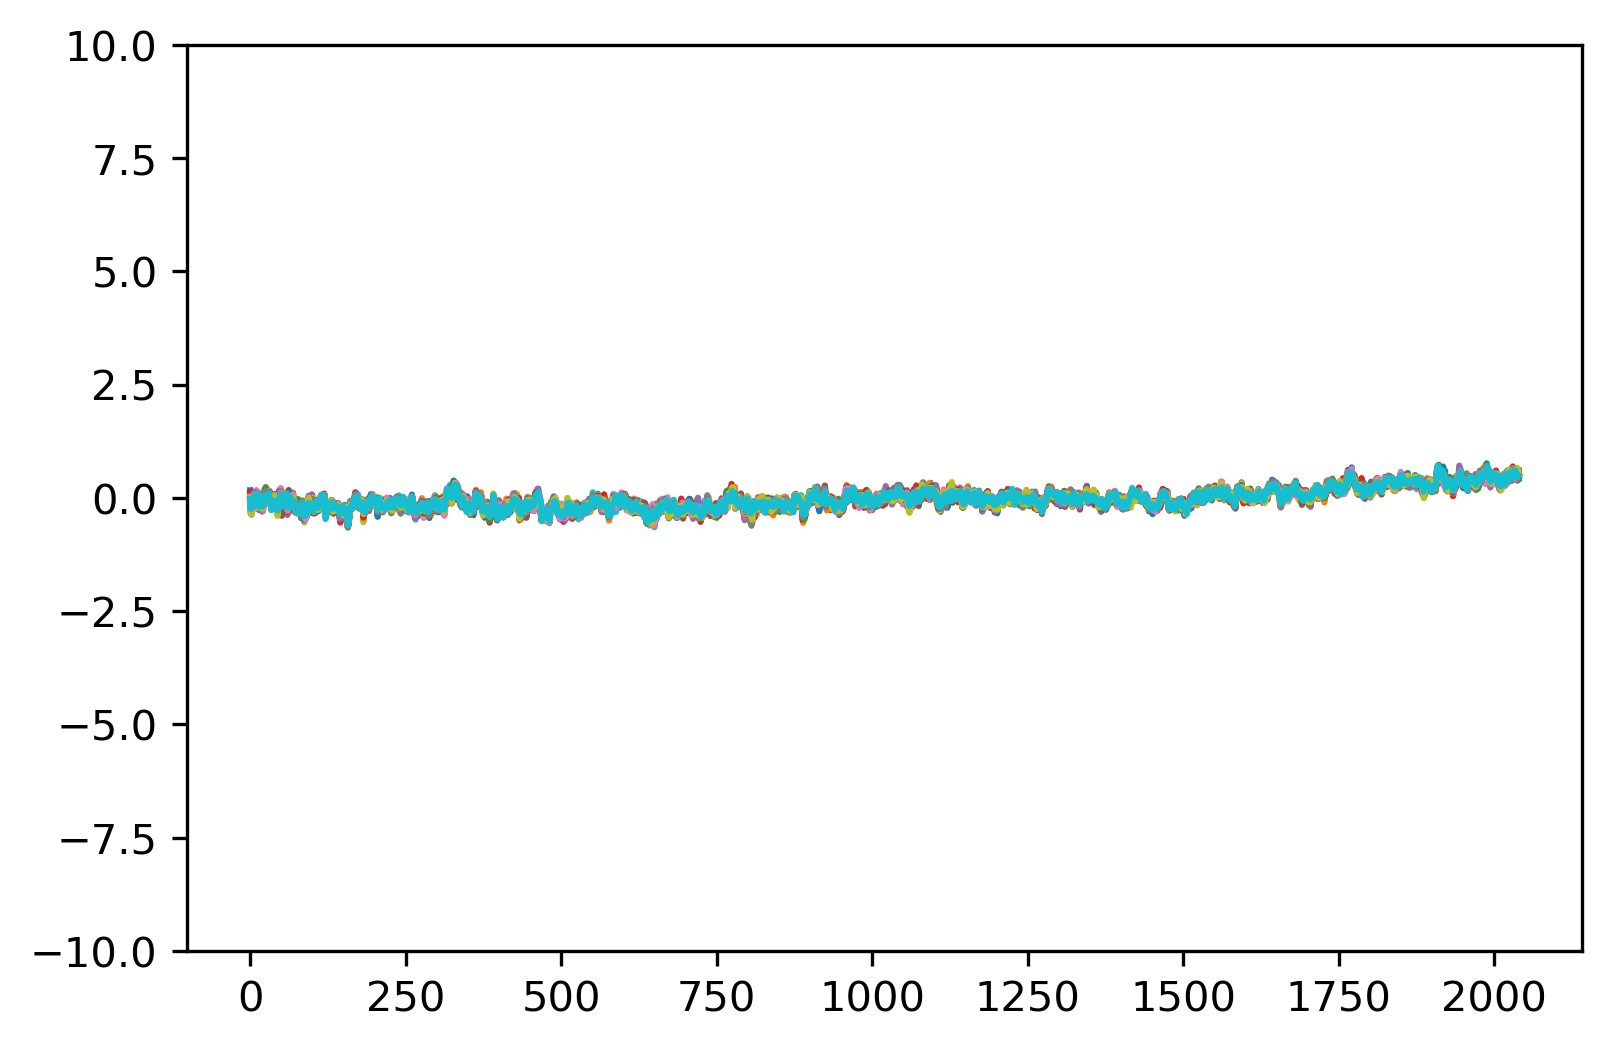

In [12]:
for it in range(20):
    plt.plot(Xa_dcomp_all['tas'][it,0,:])

plt.ylim(-10,10)

In [18]:
valid_dsource = 'cesm_lme_Amon'
fdic_valid = limkb.build_training_dic(valid_dsource)

In [66]:
LIMd['exp_setup']['lat_cutoff']['sit'] = 40
LIMd['exp_setup']['lat_cutoff']['sit']

40

In [67]:
full_names, areawt_name, month_names = limbuild.load_full_names(valid_dsource)

areacell_dict_all = {}
areacell = {}
for var in limvars:
    areacell_dict = {}
    areacell[var], areacell_dict_all[var] = limkb.load_data(areawt_name[var], areacell_dict, fdic_valid, 
                                                            remove_climo=False, detrend=False, verbose=False, 
                                                            lat_cutoff=LIMd['exp_setup']['lat_cutoff'][var])

Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 0.1
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 0.1
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 0.1
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 0.1
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 40
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 40


In [68]:
Xa_dcomp_all['sic'][i,:,:].min()

-0.6980908292195893

In [69]:
tot_var_forecast_all = {}
var_dict = LIMd['var_dict']

for var in limvars: 
    tot_var_forecast = np.zeros((niters,t_total))
    
    print('Working on '+var)
    units = areacell_dict_all[var][areawt_name[var]]['units']

    if 'km' in units:
        acell = areacell[var]
    elif 'centi' in units: 
        print('changing cellarea units from '+
              str(areacell_dict_all[var][areawt_name[var]]['units'])+' to km^2')
        acell = areacell[var]*(1e-10)
        units = 'km^2'
    else: 
        print('changing cellarea units from '+
              str(areacell_dict_all[var][areawt_name[var]]['units'])+' to km^2')
        acell = areacell[var]*(1e-6)
        units = 'km^2'
    
    for i,it in enumerate(it_list):
        if var == 'sic':
            nlon = int(var_dict[var]['var_ndof']/var_dict[var]['lat'].shape[0])
            sic_cutoff = np.where(Xa_dcomp_all[var][i,:,:])
            tot_var_forecast[i,:] = oda.calc_tot_si_checks(Xa_dcomp_all[var][i,:,:],acell,units,
                                                           var_dict[var]['lat'],nlon,lat_cutoff=0.0)
        else: 
            tot_var_forecast[i,:] = oda.global_mean(Xa_dcomp_all[var][i,:,:],acell)
            
    tot_var_forecast_all[var] = tot_var_forecast

Working on tas
changing cellarea units from m^2 to km^2
Working on tos
changing cellarea units from m^2 to km^2
Working on psl
changing cellarea units from m^2 to km^2
Working on zg
changing cellarea units from m^2 to km^2
Working on sit
changing cellarea units from m^2 to km^2
Working on sic
changing cellarea units from m^2 to km^2


In [70]:
acell.shape

(3888,)

In [71]:
full_names = {'tas':'Surface air temperature ($^\circ$C)', 
              'tos':'Sea surface temperature ($^\circ$C)',
              'psl':'Sea level pressure (Pa)',
              'zg': '500 hPa Geopotential Height (m)',
              'sit': 'Sea ice thickness (m)',
              'sic': 'Sea ice area (10$^6$ km$^2$)'}

var_units = {'tas':'$^\circ$C', 
              'tos':'$^\circ$C',
              'psl':'Sea level pressure',
              'zg': 'm',
              'sit': 'm',
              'sic': '10$^6$ km$^2$'}

Text(0, 0.5, 'Northern hemisphere mean')

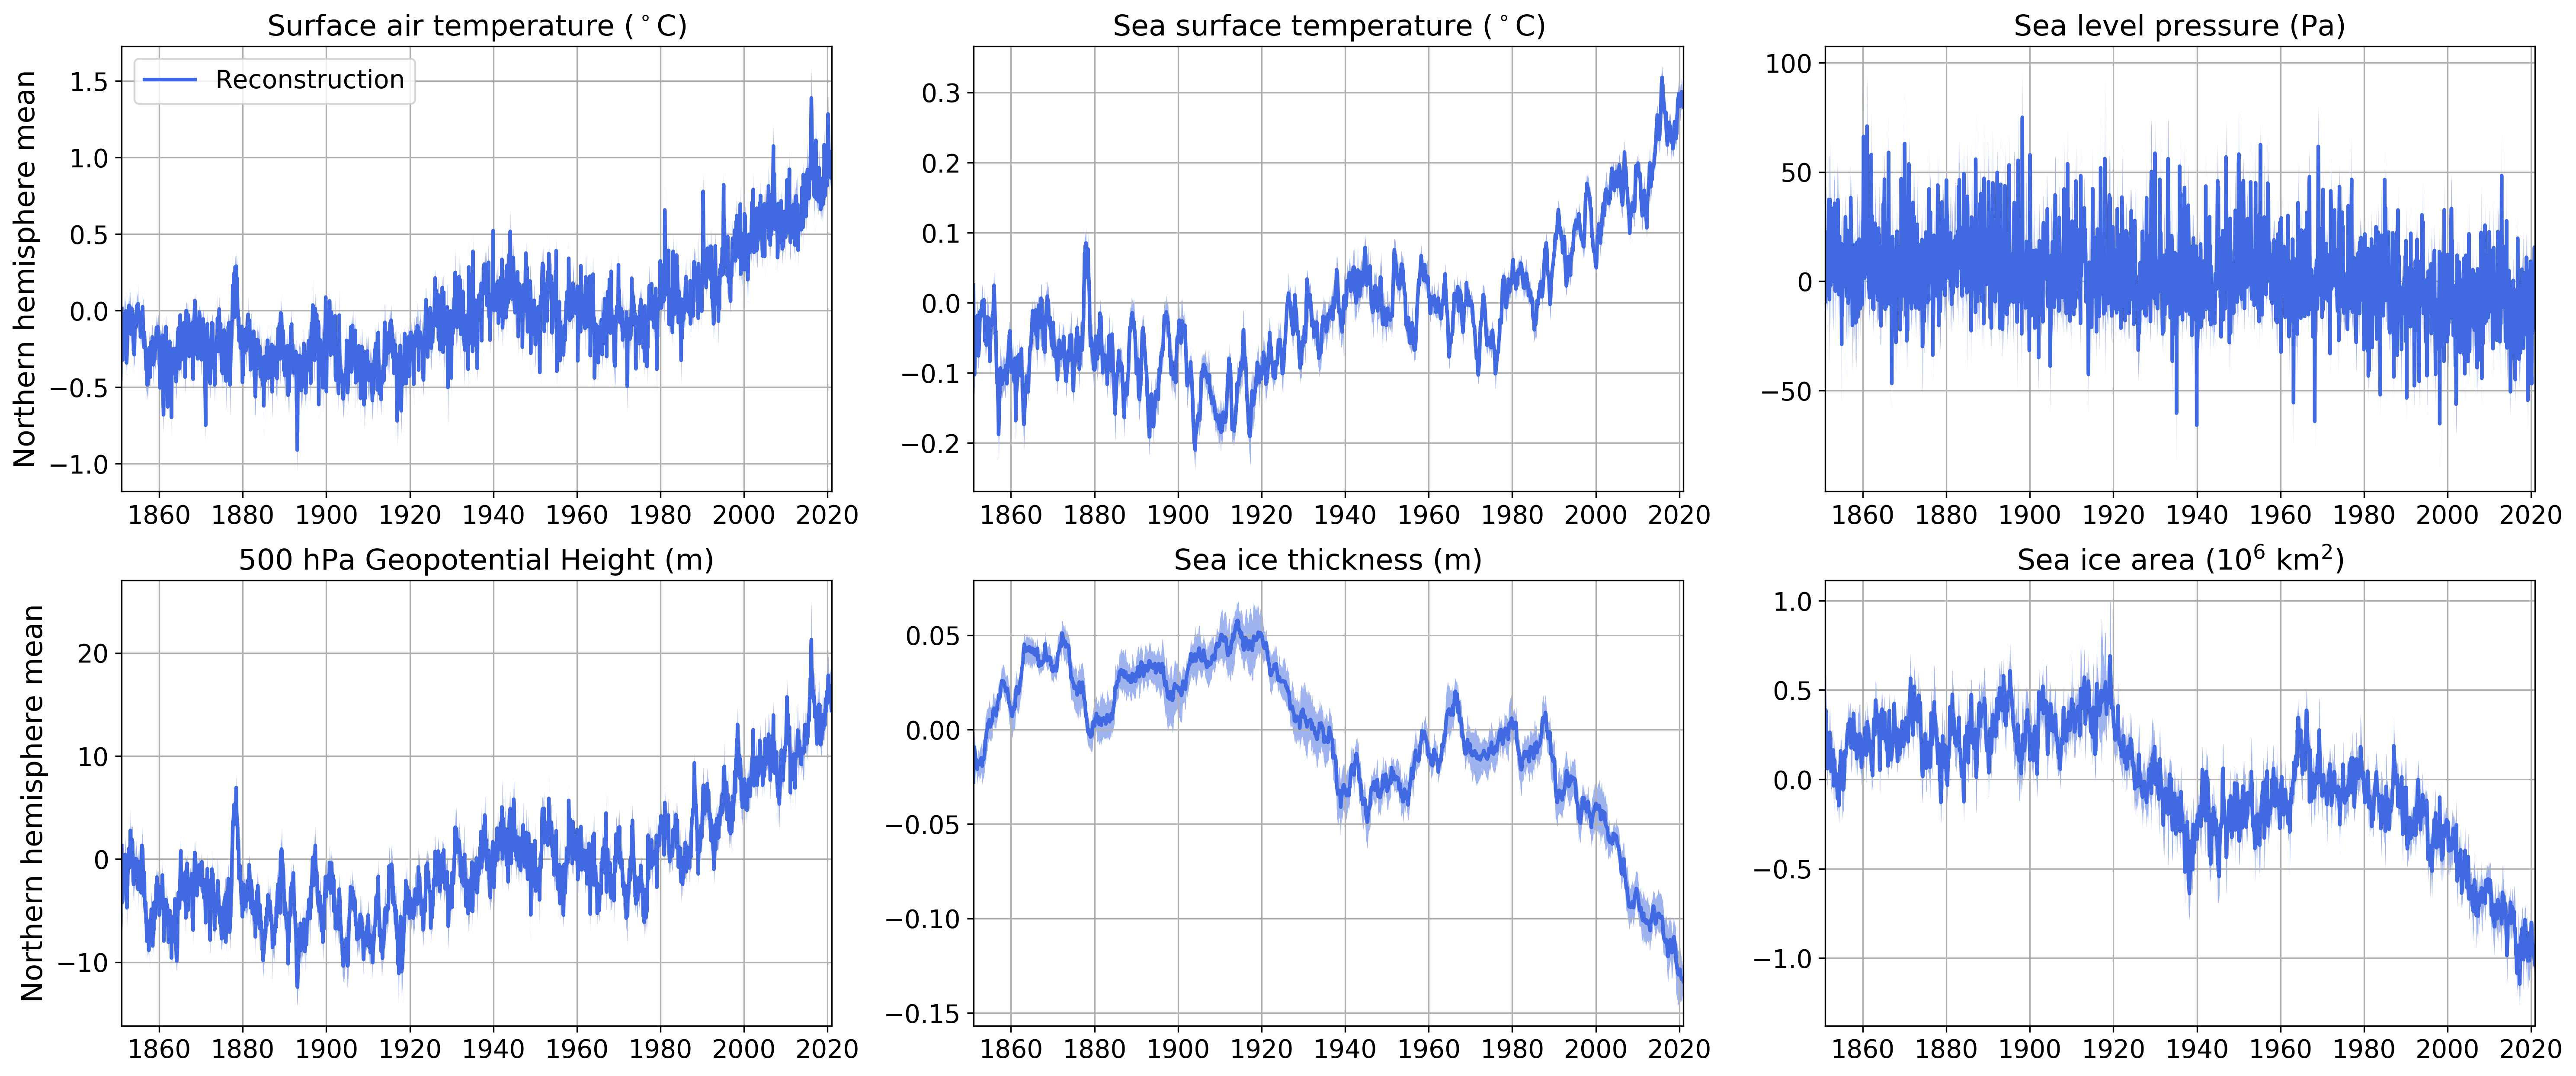

In [72]:
fig,axs = plt.subplots(2,3, figsize=(24,10))
ax = axs.flatten()

#ax[0].plot(GIS_time,GIS_nhmean, color='k',label='GISTEMP')

for i,var in enumerate(limvars):
    if 'sic' in var: 
        forecast = tot_var_forecast_all[var]*1e-6
    else: 
        forecast = tot_var_forecast_all[var]
    
    ax[i].plot(time, np.mean(forecast,axis=0), label='Reconstruction', color='royalblue',linewidth=2)
    ax[i].fill_between(time, np.percentile(forecast,2.5,axis=0), np.percentile(forecast,97.5,axis=0),
                       alpha=0.5, color='royalblue', linewidth=0.0)


    ax[i].set_title(full_names[var], fontsize=16)
    ax[i].grid()
    ax[i].set_xlim(time[0],time[-1])
#     ax[i].set_ylabel(var_units[var], fontsize=16)
    ax[i].tick_params(axis='both', which='major', labelsize=14)
#     if 'psl' in var:
#         ax[i].set_ylim(-50,50)

ax[0].legend(fontsize=14)
ax[0].set_ylabel('Northern hemisphere mean', fontsize=16)
ax[3].set_ylabel('Northern hemisphere mean', fontsize=16)

Text(0, 0.5, 'Northern hemisphere mean')

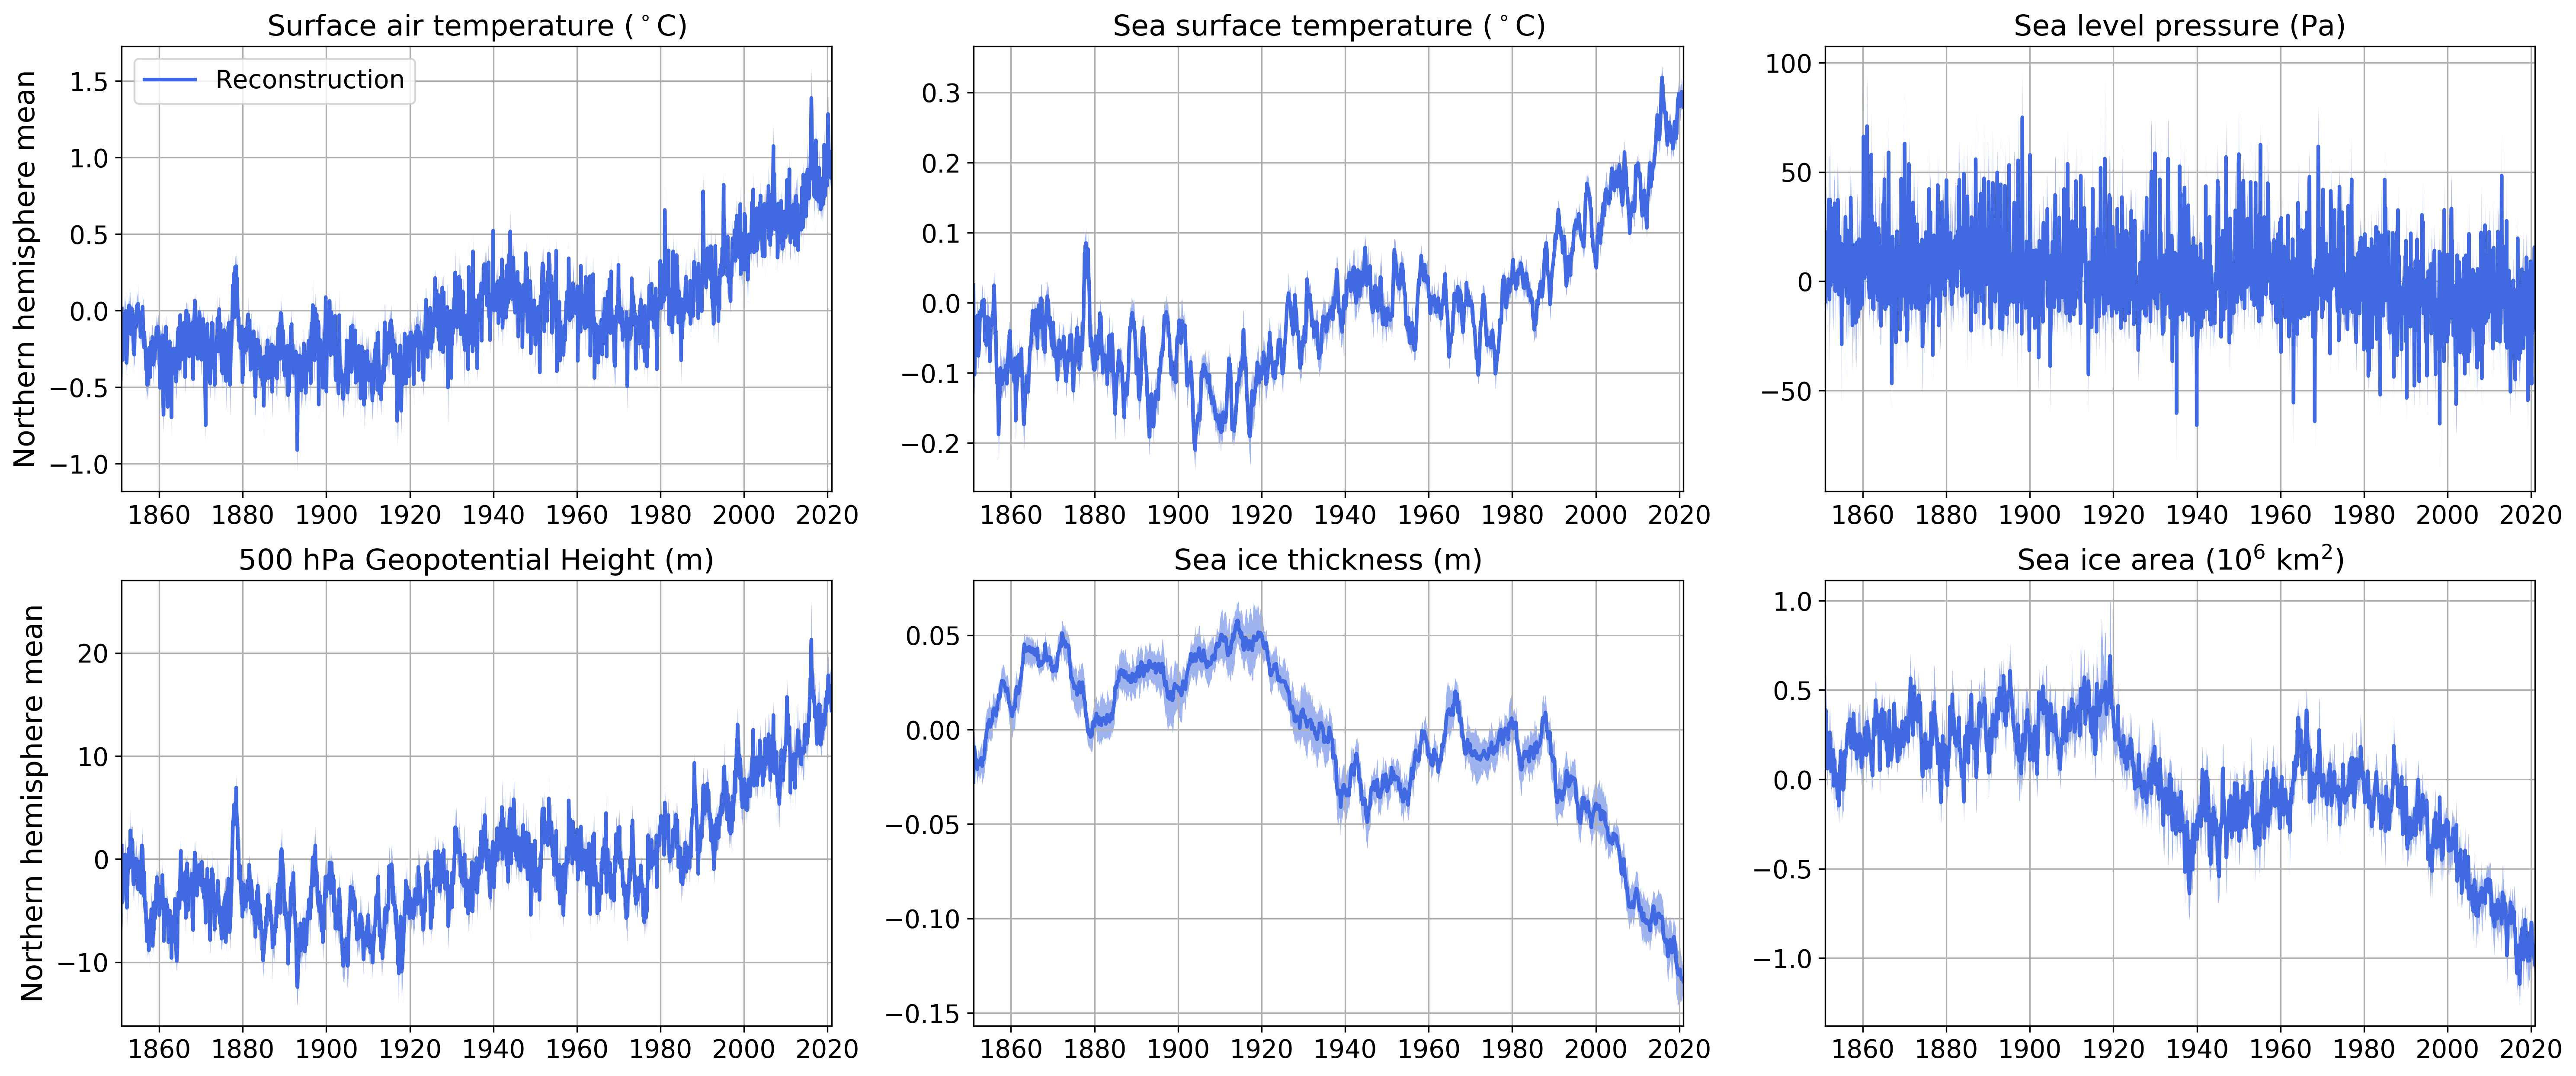

In [19]:
fig,axs = plt.subplots(2,3, figsize=(24,10))
ax = axs.flatten()

#ax[0].plot(GIS_time,GIS_nhmean, color='k',label='GISTEMP')

for i,var in enumerate(limvars):
    if 'sic' in var: 
        forecast = tot_var_forecast_all[var]*1e-6
    else: 
        forecast = tot_var_forecast_all[var]
    
    ax[i].plot(time, np.mean(forecast,axis=0), label='Reconstruction', color='royalblue',linewidth=2)
    ax[i].fill_between(time, np.percentile(forecast,2.5,axis=0), np.percentile(forecast,97.5,axis=0),
                       alpha=0.5, color='royalblue', linewidth=0.0)


    ax[i].set_title(full_names[var], fontsize=16)
    ax[i].grid()
    ax[i].set_xlim(time[0],time[-1])
#     ax[i].set_ylabel(var_units[var], fontsize=16)
    ax[i].tick_params(axis='both', which='major', labelsize=14)
#     if 'psl' in var:
#         ax[i].set_ylim(-50,50)

ax[0].legend(fontsize=14)
ax[0].set_ylabel('Northern hemisphere mean', fontsize=16)
ax[3].set_ylabel('Northern hemisphere mean', fontsize=16)

In [28]:
areacell['sit'].shape

(3168,)

### Calculate total Arctic sea ice volume: 

In [85]:
# tot_var_forecast_all = {}
var_dict = LIMd['var_dict']
var_sic = 'sic'
var_sit = 'sit'

tot_vol_forecast = np.zeros((niters,t_total))

print('Working on '+var)
units = areacell_dict_all[var_sic][areawt_name[var_sic]]['units']

if 'km' in units:
    acell = areacell[var_sic]
elif 'centi' in units: 
    print('changing cellarea units from '+
          str(areacell_dict_all[var][areawt_name[var_sic]]['units'])+' to km^2')
    acell = areacell[var_sic]*(1e-10)
    units = 'km^2'
else: 
    print('changing cellarea units from '+
          str(areacell_dict_all[var_sic][areawt_name[var_sic]]['units'])+' to km^2')
    acell = areacell[var_sic]*(1e-6)
    units = 'km^2'

for i,it in enumerate(it_list):      
    sit = Xa_dcomp_all[var_sit][i,:,:]*1e-3
    nlon = int(var_dict[var_sic]['var_ndof']/var_dict[var_sic]['lat'].shape[0])
    
    tot_vol_forecast[i,:] = calc_tot_sivol_checks(sit,acell,units, var_dict[var_sic]['lat'],
                                                  nlon,lat_cutoff=49.0)

tot_var_forecast_all['sivol'] = tot_vol_forecast

Working on sic
changing cellarea units from m^2 to km^2
not changing units of cell area
not changing units of cell area
not changing units of cell area
not changing units of cell area
not changing units of cell area
not changing units of cell area
not changing units of cell area
not changing units of cell area
not changing units of cell area
not changing units of cell area
not changing units of cell area
not changing units of cell area
not changing units of cell area
not changing units of cell area
not changing units of cell area
not changing units of cell area
not changing units of cell area
not changing units of cell area
not changing units of cell area
not changing units of cell area


## Load PIOMAS data (Schweiger et al 2019)

In [86]:
piomas_dir = '/home/disk/chaos/mkb22/Documents/SeaIceData/si_thickness/PIOMAS/'
piomas_file1 = 'piomas20c.1901.2010.vol.avg.month.nc'


In [87]:
piomas_data = xr.open_dataset(piomas_dir+piomas_file1)

In [88]:
piomas_data

<xarray.Dataset>
Dimensions:  (time: 1320)
Coordinates:
  * time     (time) datetime64[ns] 1901-01-01 1901-02-01 ... 2010-12-01
Data variables:
    volume   (time) float32 ...
Attributes:
    Producer:                Axel Schweiger
    Product:                 piomas20c
    Version:                 v1.0
    NetCDF Production Date:  20190919

In [89]:
piomas_data['volume_noclimo'] = piomas_data.volume.groupby('time.month') - piomas_data.volume.groupby('time.month').mean()

In [90]:
piomas_time = pd.to_datetime(piomas_data.time.values)
piomas_vol = piomas_data['volume_noclimo'].values 

In [91]:
anom_start,anom_end, piomas_vol_anom[936:].shape, recon_vol_anom[piomas_comp_inds].shape

(Timestamp('1979-01-01 00:00:00'),
 Timestamp('2010-12-01 00:00:00'),
 (384,),
 (383,))

In [92]:
anom_end = piomas_time[-1]
anom_start = piomas_time[936]
pio_start = piomas_time[0]

piomas_comp_inds = (time<=anom_end)&(time>=anom_start)
PIOMAS_sat_inds = (piomas_time<=anom_end)&(piomas_time>=anom_start)
piomas_period_inds = (time<=anom_end)&(time>=pio_start)

In [93]:
anom_start, anom_end, pio_start

(Timestamp('1979-01-01 00:00:00'),
 Timestamp('2010-12-01 00:00:00'),
 Timestamp('1901-01-01 00:00:00'))

In [94]:
piomas_vol_anom = piomas_vol - np.nanmean(piomas_vol[PIOMAS_sat_inds])

recon_vol = np.nanmean(tot_var_forecast_all['sivol'],axis=0)
recon_vol_anom = recon_vol - np.nanmean(recon_vol[piomas_comp_inds])

In [95]:
corr_recon_piomas, ce_recon_piomas = oda.calc_corr_ce(piomas_vol_anom[:-1],recon_vol_anom[piomas_period_inds])
corr_recon_piomas**2, ce_recon_piomas

(0.19011047648072132, -1.0216046520898763)

In [96]:
corr_recon_piomas_sat, ce_recon_piomas_sat = oda.calc_corr_ce(piomas_vol_anom[936:-1],
                                                              recon_vol_anom[piomas_comp_inds])

corr_recon_piomas_sat**2, ce_recon_piomas_sat

(0.9427385993792554, 0.8878374426184342)

/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


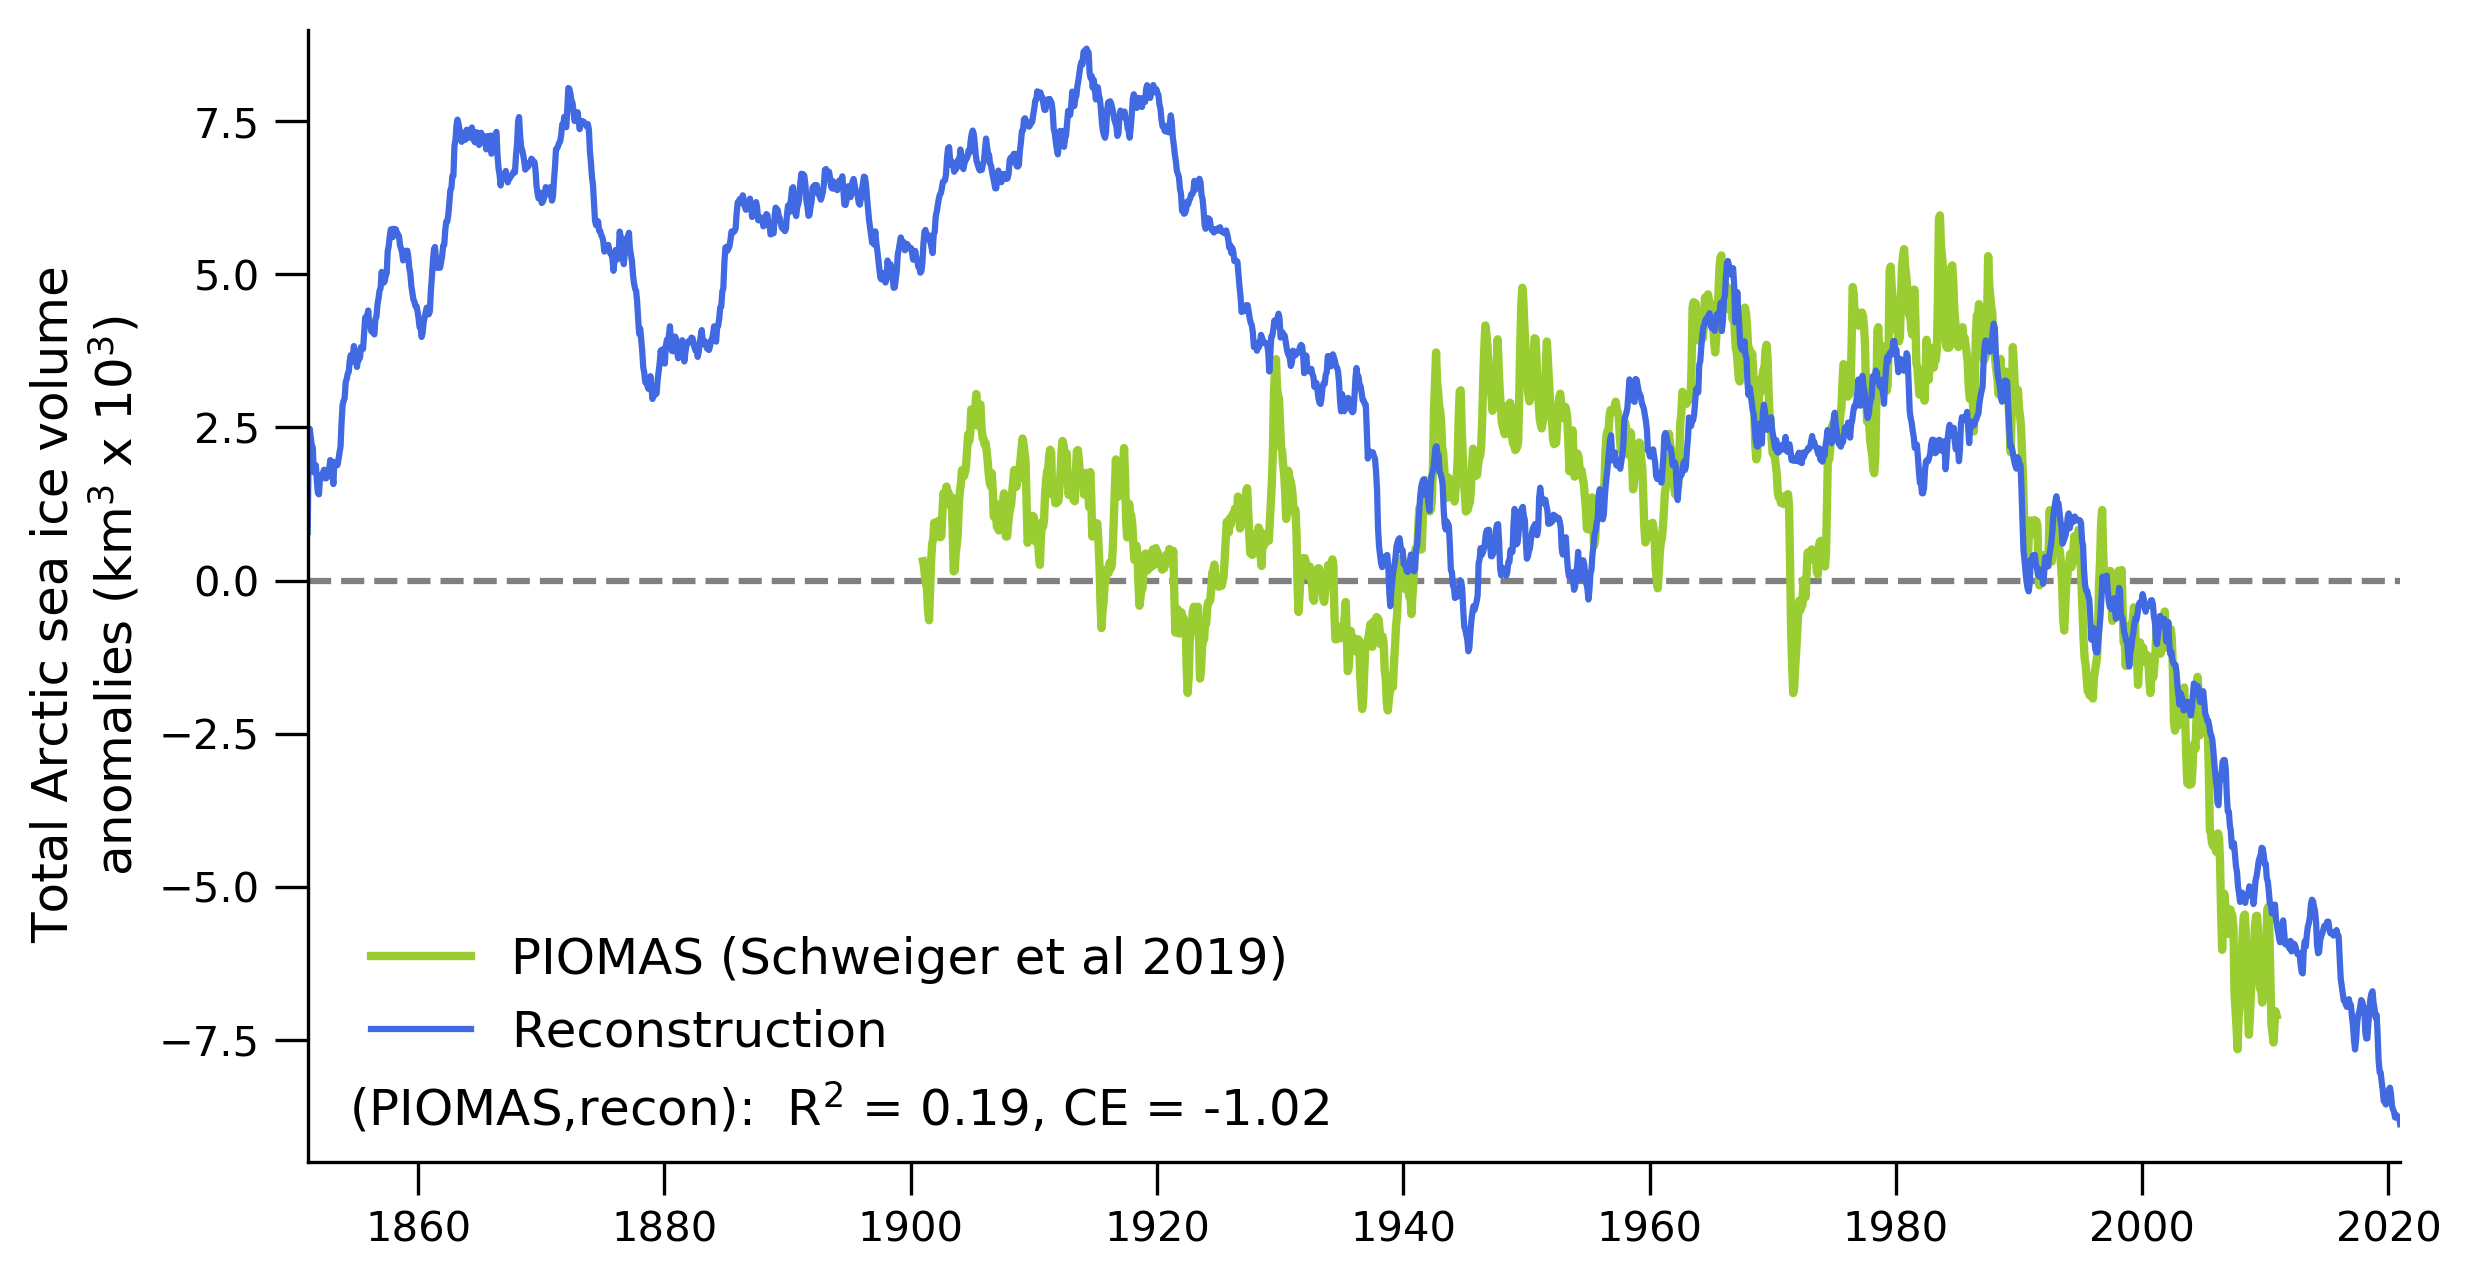

In [97]:
fig,ax = plt.subplots(1,1, figsize=(9,5))
plt.axhline(0,linestyle='--',color='gray')

ax.plot(piomas_time, piomas_vol_anom*1e-3, color='yellowgreen',label='PIOMAS (Schweiger et al 2019)', 
        linewidth=2)

ax.plot(time,recon_vol_anom*1e-3, 
        label='Reconstruction', color='royalblue', linewidth=1.5)

#ax.grid()
plt.xlim(time[0],time[-1])
plt.ylim(-9.5,9)

ax.legend(bbox_to_anchor=[0.49,0.24],fontsize=12, frameon=False)
ax.set_ylabel('Total Arctic sea ice volume \nanomalies (km$^3$ x $10^3$)', fontsize=12)

plt.text(time[40],-8.9,'(PIOMAS,recon):  R$^2$ = '+str(np.round(corr_recon_piomas**2,2))+
         ', CE = '+str(np.round(ce_recon_piomas,2)), fontsize=12)

ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


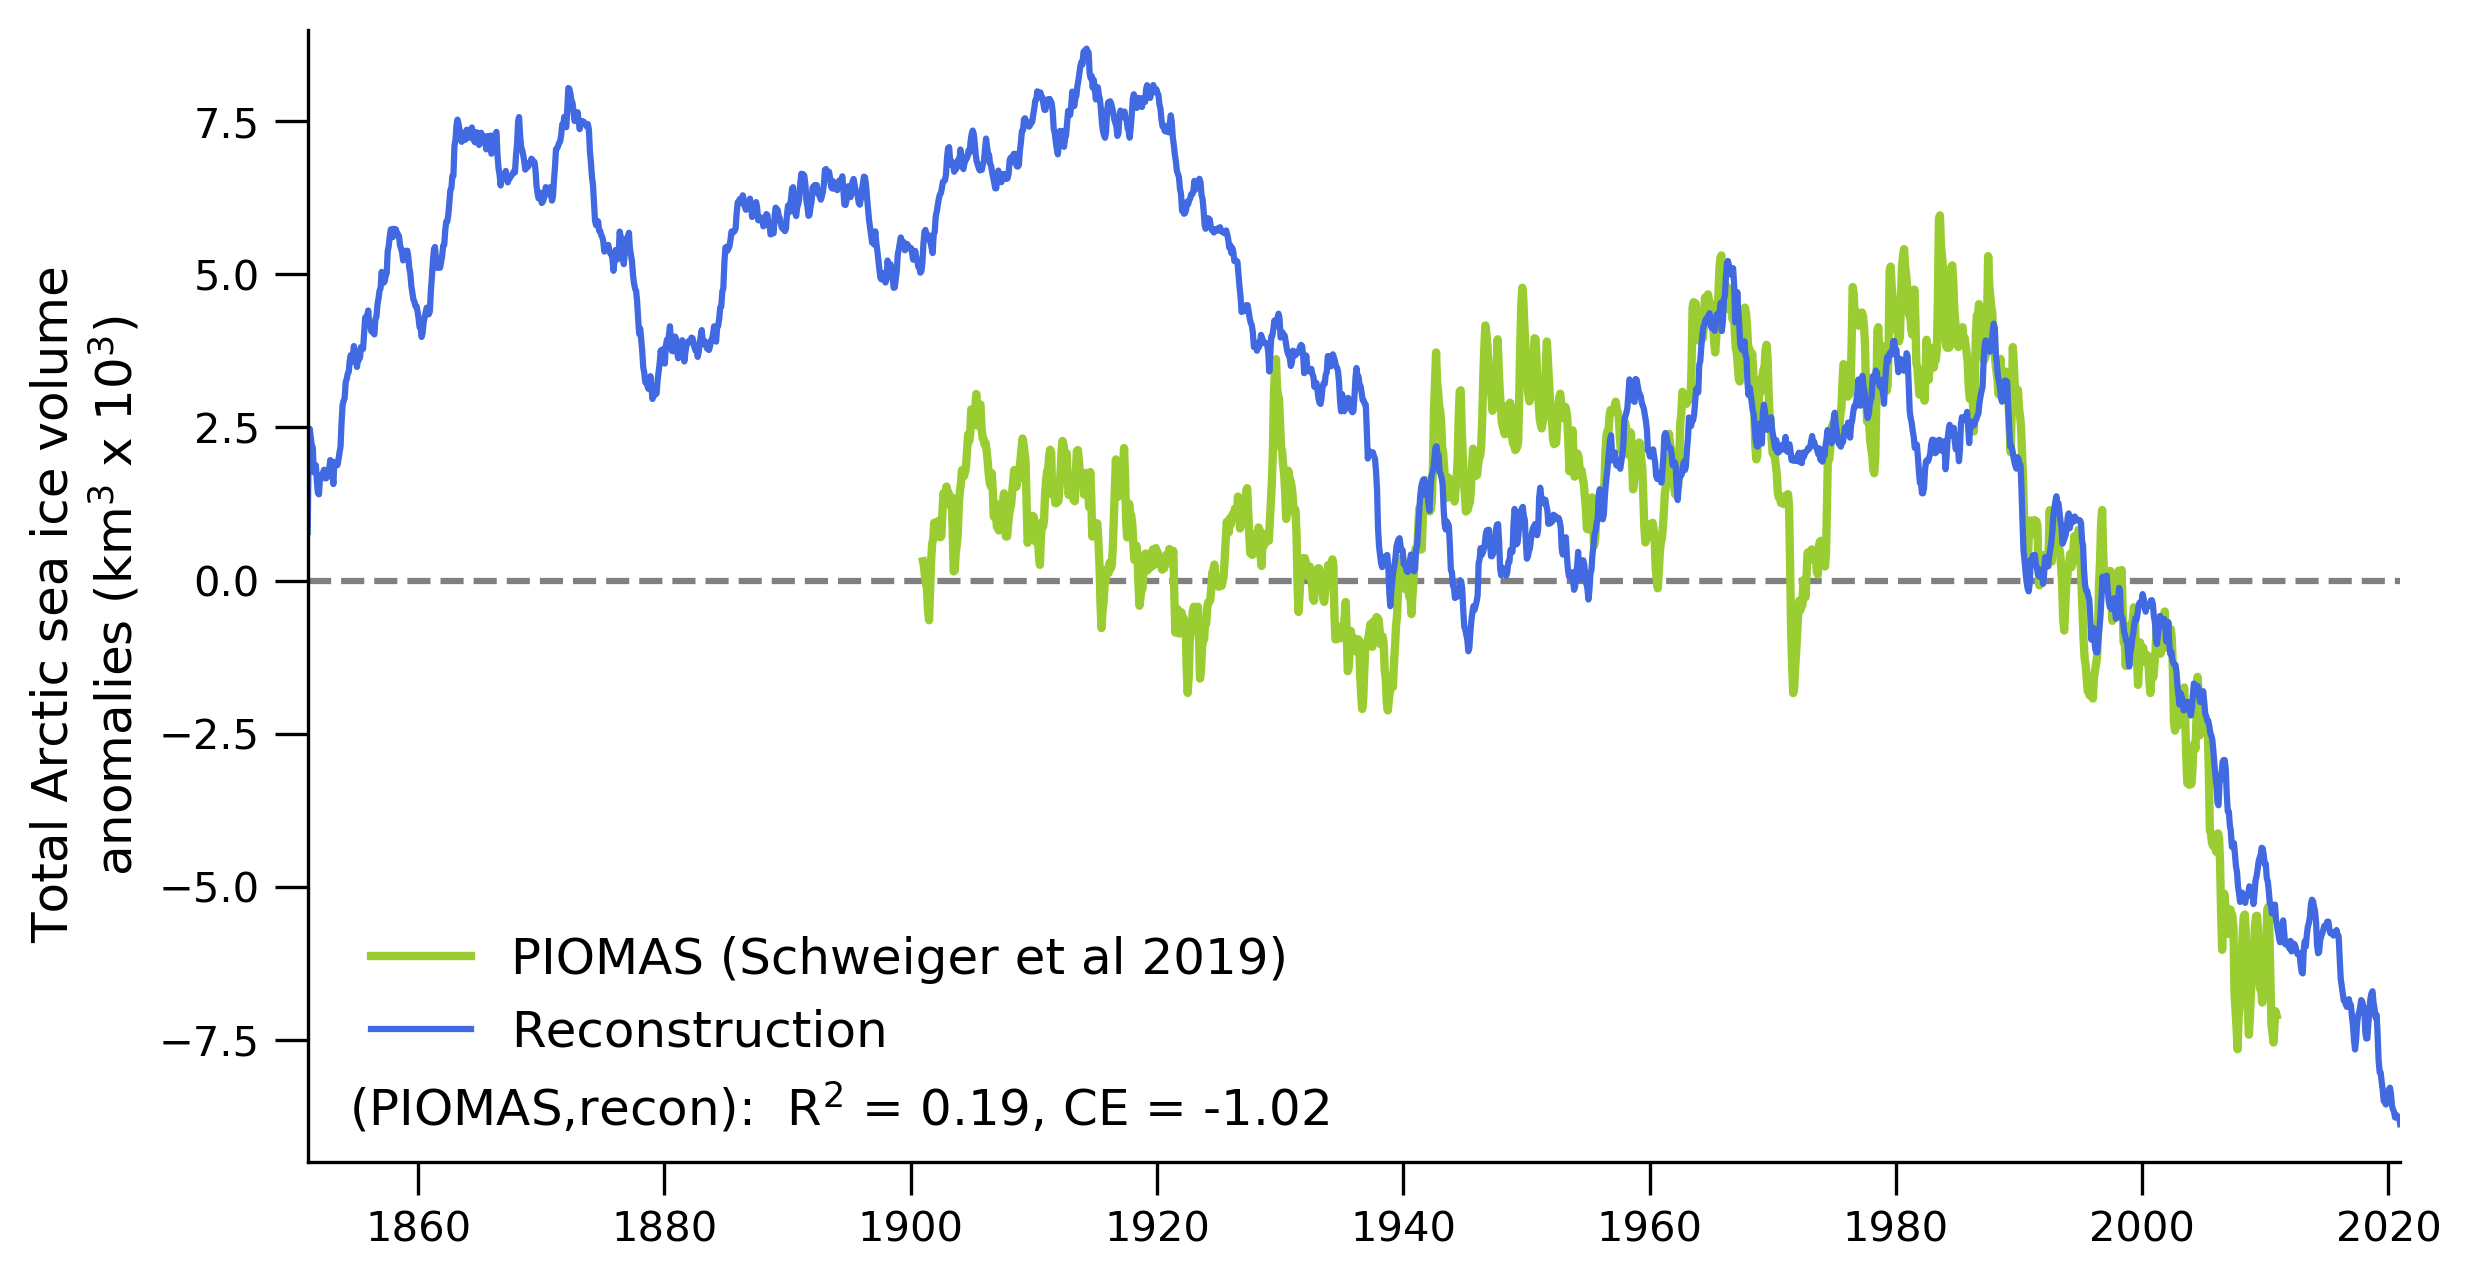

In [98]:
fig,ax = plt.subplots(1,1, figsize=(9,5))
plt.axhline(0,linestyle='--',color='gray')

ax.plot(piomas_time, piomas_vol_anom*1e-3, color='yellowgreen',label='PIOMAS (Schweiger et al 2019)', 
        linewidth=2)

ax.plot(time,recon_vol_anom*1e-3, 
        label='Reconstruction', color='royalblue', linewidth=1.5)

#ax.grid()
plt.xlim(time[0],time[-1])
plt.ylim(-9.5,9)

ax.legend(bbox_to_anchor=[0.49,0.24],fontsize=12, frameon=False)
ax.set_ylabel('Total Arctic sea ice volume \nanomalies (km$^3$ x $10^3$)', fontsize=12)

plt.text(time[40],-8.9,'(PIOMAS,recon):  R$^2$ = '+str(np.round(corr_recon_piomas**2,2))+
         ', CE = '+str(np.round(ce_recon_piomas,2)), fontsize=12)

ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

savename ='figures/tas_recon_LIMmultimod_Had50obs_20it_comparison_gis_be_had.png'

/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


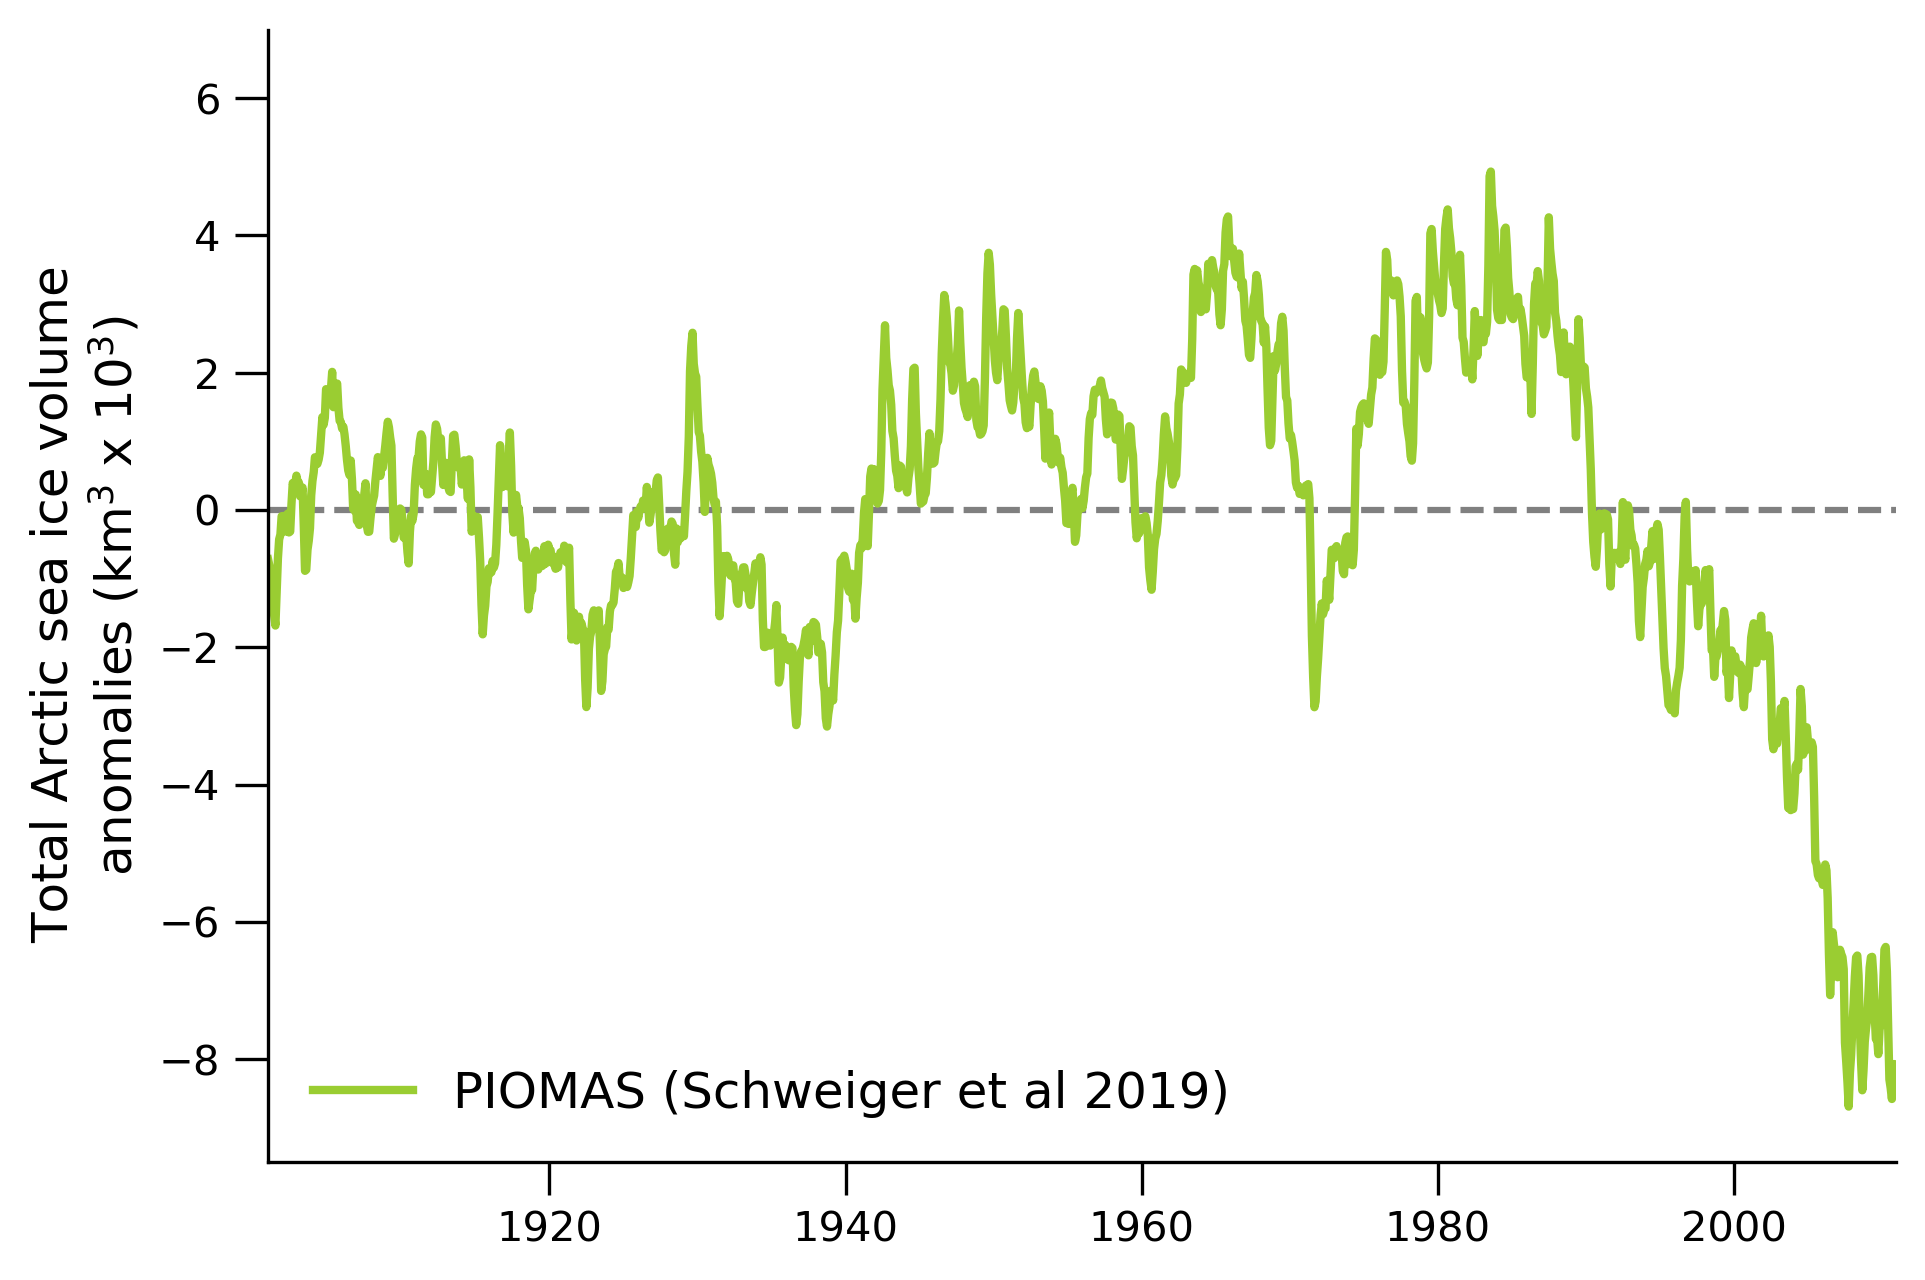

In [24]:
fig,ax = plt.subplots(1,1, figsize=(7,5))
plt.axhline(0,linestyle='--',color='gray')

ax.plot(piomas_time, piomas_vol_anom*1e-3, color='yellowgreen',label='PIOMAS (Schweiger et al 2019)', 
        linewidth=2)

#ax.grid()
plt.xlim(piomas_time[0],piomas_time[-1])
plt.ylim(-9.5,7)

ax.legend(loc='lower left',fontsize=12, frameon=False)
ax.set_ylabel('Total Arctic sea ice volume \nanomalies (km$^3$ x $10^3$)', fontsize=12)


ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

savename ='figures/tas_recon_LIMmultimod_Had50obs_20it_comparison_gis_be_had.png'

In [214]:
piomas_dir = '/home/disk/chaos/mkb22/Documents/SeaIceData/si_thickness/PIOMAS/'
piomas_file2 = 'piomas20c.area.1901.2010.v1.0.nc'

piomas_area = xr.open_dataset(piomas_dir+piomas_file2)

In [217]:
piomas_area

<xarray.Dataset>
Dimensions:       (month: 1320, time: 1320, x: 120, y: 360, year: 1320)
Coordinates:
    Longitude     (x, y) float32 319.5 320.5 321.5 322.5 ... 317.9 318.4 318.8
    Latitude      (x, y) float32 48.99 48.99 48.99 48.99 ... 72.71 72.71 72.71
  * time          (time) datetime64[ns] 1901-01-01 1901-02-01 ... 2010-12-01
  * month         (month) int64 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12
  * year          (year) int64 1901 1901 1901 1901 1901 ... 2010 2010 2010 2010
Dimensions without coordinates: x, y
Data variables:
    sic           (time, x, y) float32 ...
    OceanMask     (x, y) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    GridCellArea  (x, y) float32 4.955e+03 4.955e+03 4.955e+03 ... 206.4 206.7
Attributes:
    Producer:                Axel Schweiger
    Product:                 piomas20c
    Version:                 v1.0
    NetCDF Production Date:  20190429

In [221]:
piomas_area['total_sia'] = (piomas_area.sic*piomas_area.GridCellArea).sum(dim=['x','y'])

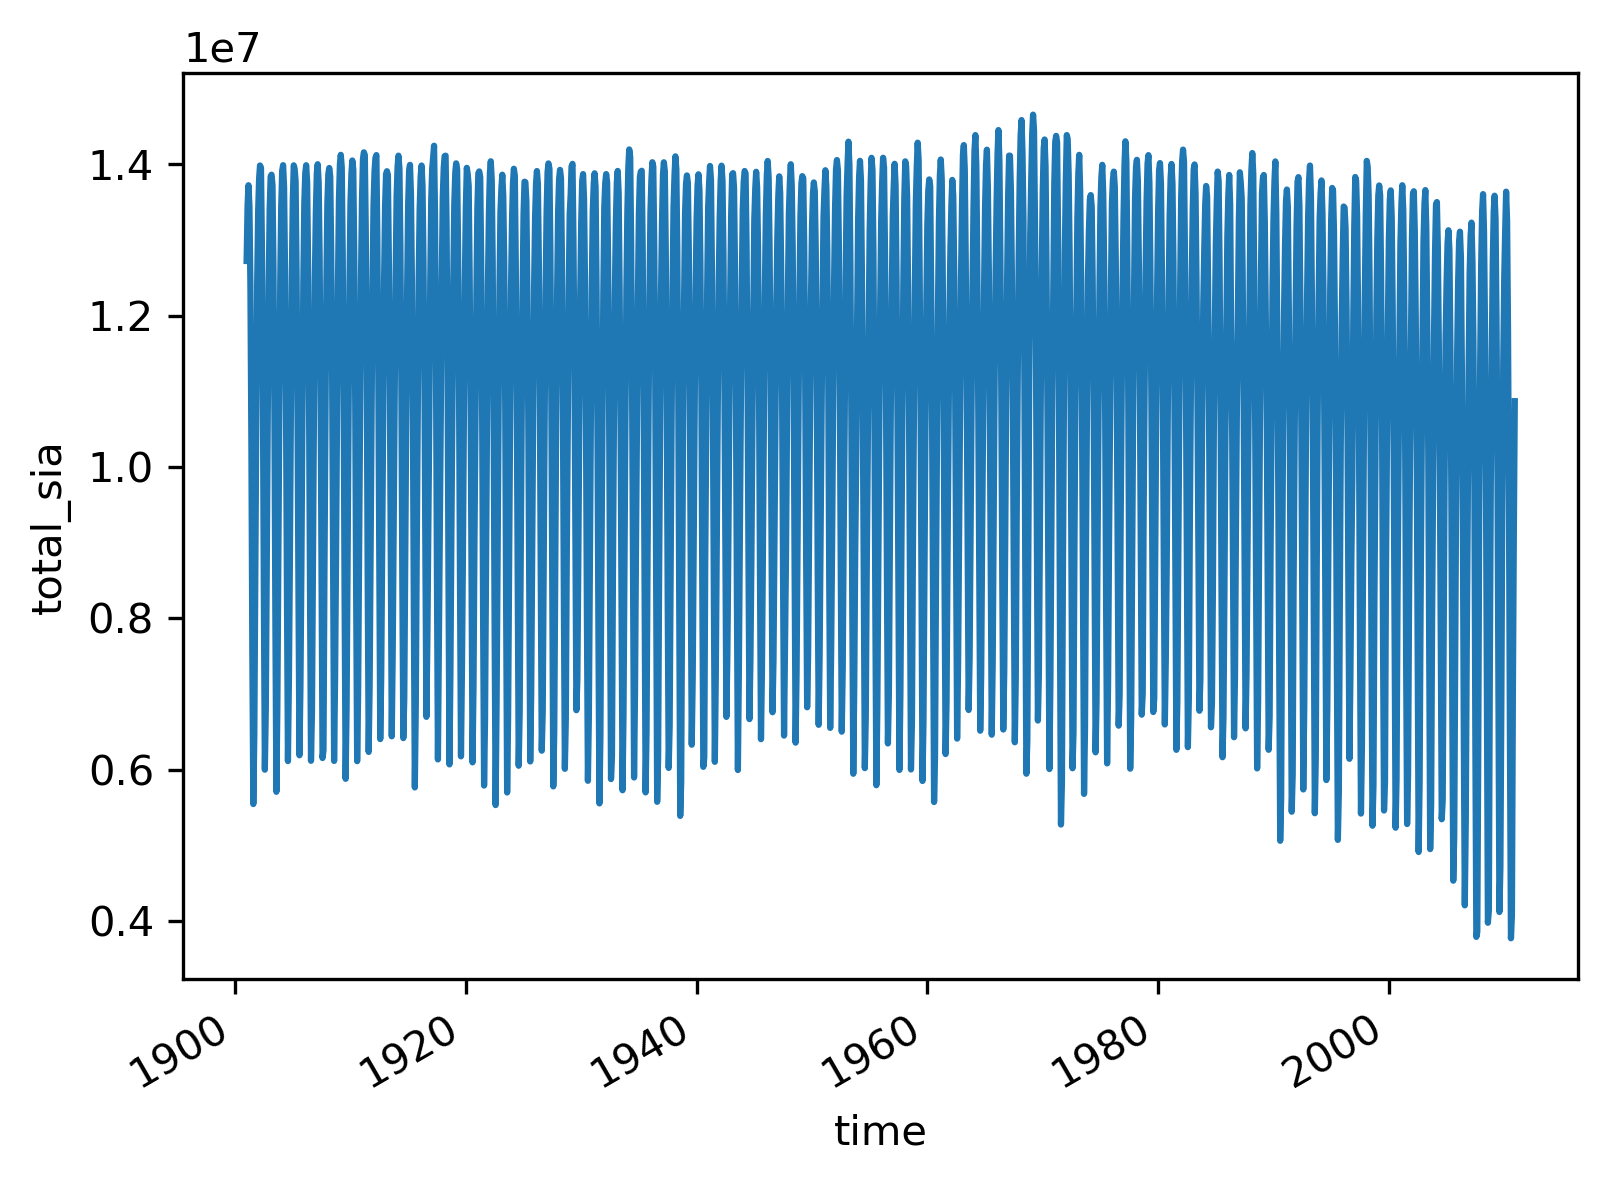

In [226]:
piomas_area['total_sia'].plot()

In [224]:
piomas_area['total_sia_anom'] = piomas_area['total_sia'].groupby('time.month') - piomas_area['total_sia'].groupby('time.month').mean()
piomas_sia_anom = piomas_area['total_sia_anom'].values

In [227]:
def load_monthly_walsh(ANOM_START,ANOM_END):
    walsh_directory = '/home/disk/chaos/mkb22/Documents/SeaIceData/Walsh2016/walsh_comparison/'

    walsh_sie_file_mo = 'Walsh_monthly_sie_km2.npz'
    walsh_sia_file_mo = 'Walsh_monthly_sia_km2.npz'

    walsh_sie_data_mo = np.load(walsh_directory + walsh_sie_file_mo)
    walsh_sia_data_mo = np.load(walsh_directory + walsh_sia_file_mo)

    walsh_sia = walsh_sia_data_mo['walsh_nh_monthly_area_total']
    walsh_sie = walsh_sie_data_mo['walsh_nh_monthly_extent_total']

    walsh_time = np.arange(1850,2014,1)
    
    return walsh_sia, walsh_sie, walsh_time

In [301]:
def load_annual_walsh(version=None):
    """
    Loads annualized total Arctic extent and area from Walsh et al version 1 or 2. 
    
    INPUTS: 
    version: integer value indicating the value of Walsh data to load (takes values: 1,2,None)
    
    OUTPUTS: 
    walsh_sia: total arctic sea ice area (km^2)
    walsh_sie: total arctic sea ice extent (km^2)
    walsh_time: years of walsh data (years)
    """
    walsh_directory = '/home/disk/chaos/mkb22/Documents/SeaIceData/Walsh2016/walsh_comparison/'
    
    if version is None: 
        vera = 2
        vere = 2
    elif version == 3: 
        vera = 2
        vere = 3
    else: 
        vera = version
        vere = version

    walsh_sie_file_an = 'Walsh_annual_sie_km2_v'+str(vere)+'.npz'
    walsh_sia_file_an = 'Walsh_annual_sia_km2_v'+str(vera)+'.npz'

    walsh_sie_data_an = np.load(walsh_directory + walsh_sie_file_an)
    walsh_sia_data_an = np.load(walsh_directory + walsh_sia_file_an)
    
    walsh_time = walsh_sie_data_an['years']
    
    if version ==2: 
        walsh_sia = walsh_sia_data_an['walsh_nh_annual_area_total']/1e6
        walsh_sie = walsh_sie_data_an['walsh_nh_annual_extent_total']/1e6
    elif version ==3:     
        walsh_sia = walsh_sia_data_an['walsh_nh_annual_area_total']/1e6
        walsh_sie = walsh_sie_data_an['walsh_nh_annual_extent_total_amn_first']/1e6
    else: 
        walsh_sia = walsh_sia_data_an['walsh_nh_annual_area_total']
        walsh_sie = walsh_sie_data_an['walsh_nh_annual_extent_total']
    
#     if ver == 1: 
#         walsh_time = np.arange(1850,2014,1)
#     else: 
#         walsh_time = np.arange(1850,2018,1)
    
    return walsh_sia, walsh_sie, walsh_time

In [237]:
def load_monthly_walsh():
    """
    Loads annualized total Arctic extent and area from Walsh et al version 1 or 2. 
    
    INPUTS: 
    version: integer value indicating the value of Walsh data to load (takes values: 1,2,None)
    
    OUTPUTS: 
    walsh_sia: total arctic sea ice area (km^2)
    walsh_sie: total arctic sea ice extent (km^2)
    walsh_time: years of walsh data (years)
    """
    walsh_directory = '/home/disk/chaos/mkb22/Documents/SeaIceData/Walsh2016/walsh_comparison/'

    walsh_sie_file_mo = 'Walsh_monthly_sie_km2.npz'
    walsh_sia_file_mo = 'Walsh_monthly_sia_km2.npz'

    walsh_sie_data_mo = np.load(walsh_directory + walsh_sie_file_mo)
    walsh_sia_data_mo = np.load(walsh_directory + walsh_sia_file_mo)
    
    walsh_time = walsh_sie_data_mo['years']
    
    if version ==2: 
        walsh_sia = walsh_sia_data_mo['walsh_nh_monthly_area_total']/1e6
        walsh_sie = walsh_sie_data_mo['walsh_nh_monthly_extent_total']/1e6
    elif version ==3:     
        walsh_sia = walsh_sia_data_mo['walsh_nh_monthly_area_total']/1e6
        walsh_sie = walsh_sie_data_mo['walsh_nh_monthly_extent_total_amn_first']/1e6
    else: 
        walsh_sia = walsh_sia_data_mo['walsh_nh_monthly_area_total']
        walsh_sie = walsh_sie_data_mo['walsh_nh_monthly_extent_total']
    
#     if ver == 1: 
#         walsh_time = np.arange(1850,2014,1)
#     else: 
#         walsh_time = np.arange(1850,2018,1)
    
    return walsh_sia, walsh_sie, walsh_time

In [248]:
walsh_sia, walsh_sie, walsh_years = load_monthly_walsh()
walsh_sia_noclimo = walsh_sia - np.mean(walsh_sia,axis=0)

nyears = walsh_years.shape[0]
#nyears = 155

# Generate times: 
t_total = nyears*12
yr1 = walsh_years[0]
years = int(yr1+np.floor((t_total-1)/12))
walsh_time = np.array([datetime.datetime(y, m, 15) for y in np.arange(yr1,yr1+nyears,1) for m in np.arange(1,13,1)])

In [256]:
anom_end = piomas_time[-1]
anom_start = piomas_time[936]
pio_start = piomas_time[0]

piomas_comp_inds = (walsh_time<=anom_end)&(walsh_time>=anom_start)
piomas_period_inds = (walsh_time<=anom_end)&(walsh_time>=pio_start)

In [257]:
corr_walsh_piomas, ce_walsh_piomas = oda.calc_corr_ce(piomas_sia_anom[:-1]*1e-6,walsh_sia_noclimo.flatten()[piomas_period_inds])
corr_walsh_piomas**2, ce_walsh_piomas

(0.29341354927047003, -0.2759756530024622)

In [259]:
walsh_sia_noclimo_anom = walsh_sia_noclimo.flatten() - np.nanmean(walsh_sia_noclimo.flatten()[piomas_comp_inds])

/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


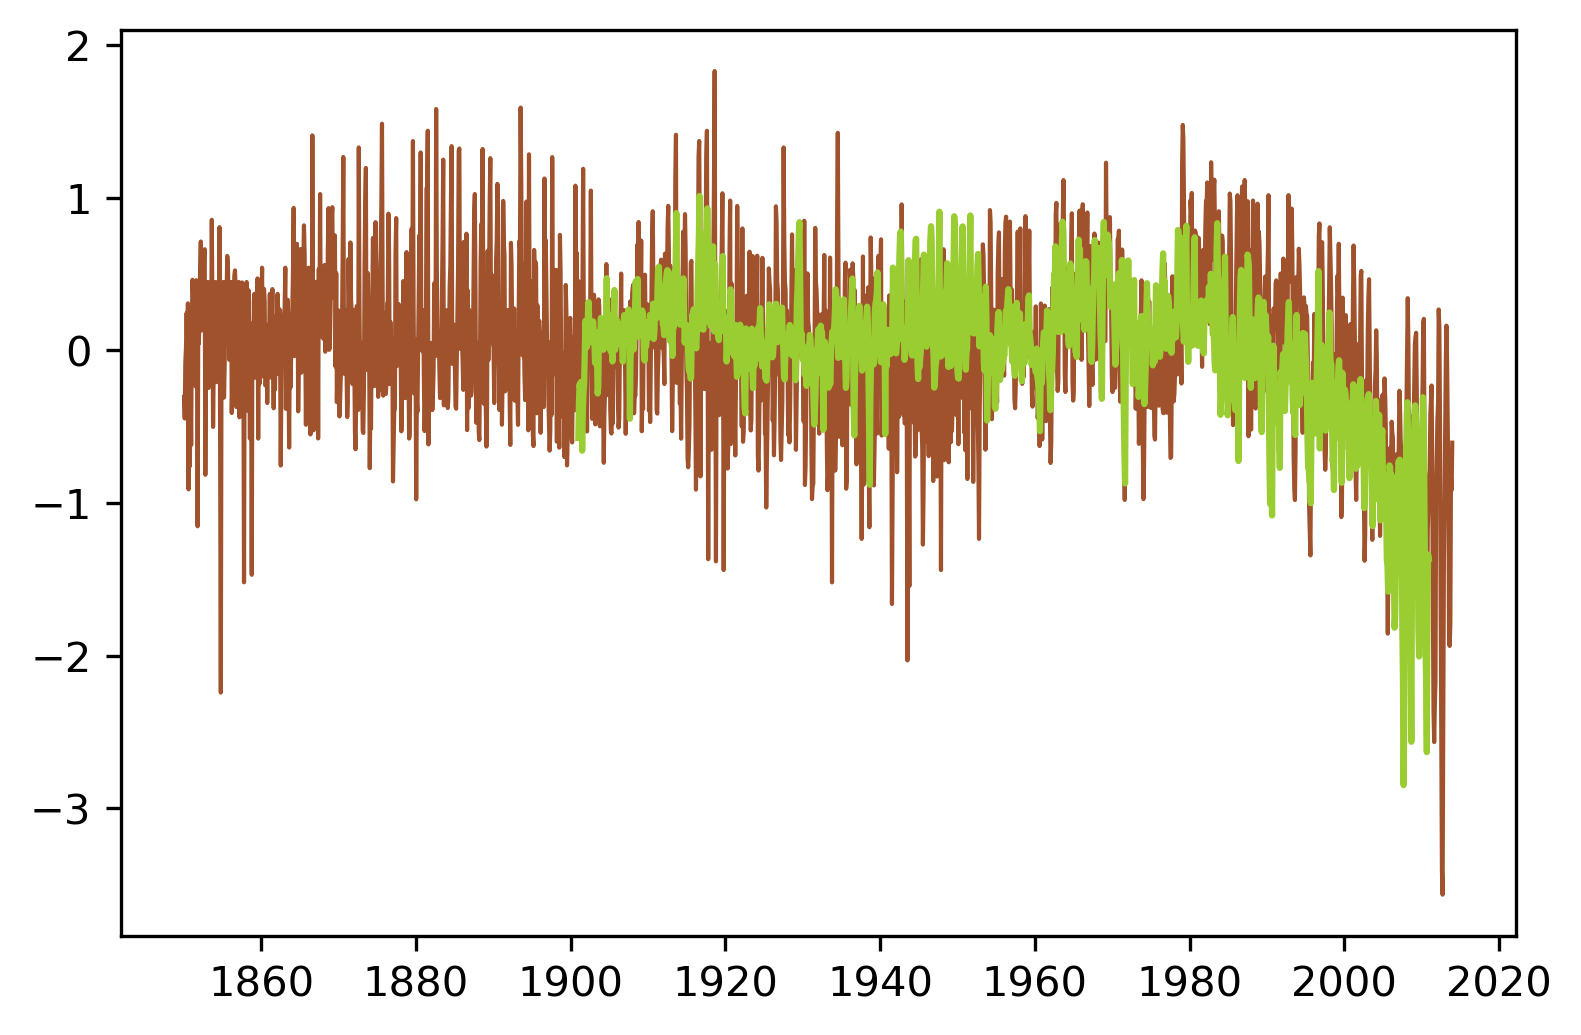

In [260]:
plt.plot(walsh_time,walsh_sia_noclimo.flatten(), color='sienna', linewidth=1)
plt.plot(piomas_time,piomas_sia_anom*1e-6, color='yellowgreen', linewidth=1.5)

In [304]:
walsh_sia_annual, walsh_sie_annual, walsh_time_annual = load_annual_walsh()

In [310]:
walsh_sia_annual_anom = walsh_sia_annual - np.nanmean(walsh_sia_annual[piomas_comp_inds_an])

In [262]:
walsh_sia_noclimo_annual = np.nanmean(walsh_sia_noclimo,axis=1)
piomas_sia_annual = np.nanmean(np.reshape(piomas_sia_anom,(110,12)),axis=1)

In [309]:
anom_end = 2010
anom_start = 1950
pio_start = 1901

piomas_comp_inds = (walsh_years<=anom_end)&(walsh_years>=anom_start)
piomas_period_inds = (walsh_years<=anom_end)&(walsh_years>=pio_start)

piomas_comp_inds_an = (walsh_time_annual<=anom_end)&(walsh_time_annual>=anom_start)
piomas_period_inds_an = (walsh_time_annual<=anom_end)&(walsh_time_annual>=pio_start)

In [298]:
walsh_sia_noclimo_annual_anom = walsh_sia_noclimo_annual - np.nanmean(walsh_sia_noclimo_annual[piomas_comp_inds])
piomas_sia_annual_anom = piomas_sia_annual - np.nanmean(piomas_sia_annual)

In [314]:
corr_walsh_piomas_an, ce_walsh_piomas_an = oda.calc_corr_ce(piomas_sia_annual_anom*1e-6,walsh_sia_annual_anom[piomas_period_inds_an]*1e-6)
corr_walsh_piomas_an**2, ce_walsh_piomas_an

(0.7491586465010701, 0.6954306224176037)

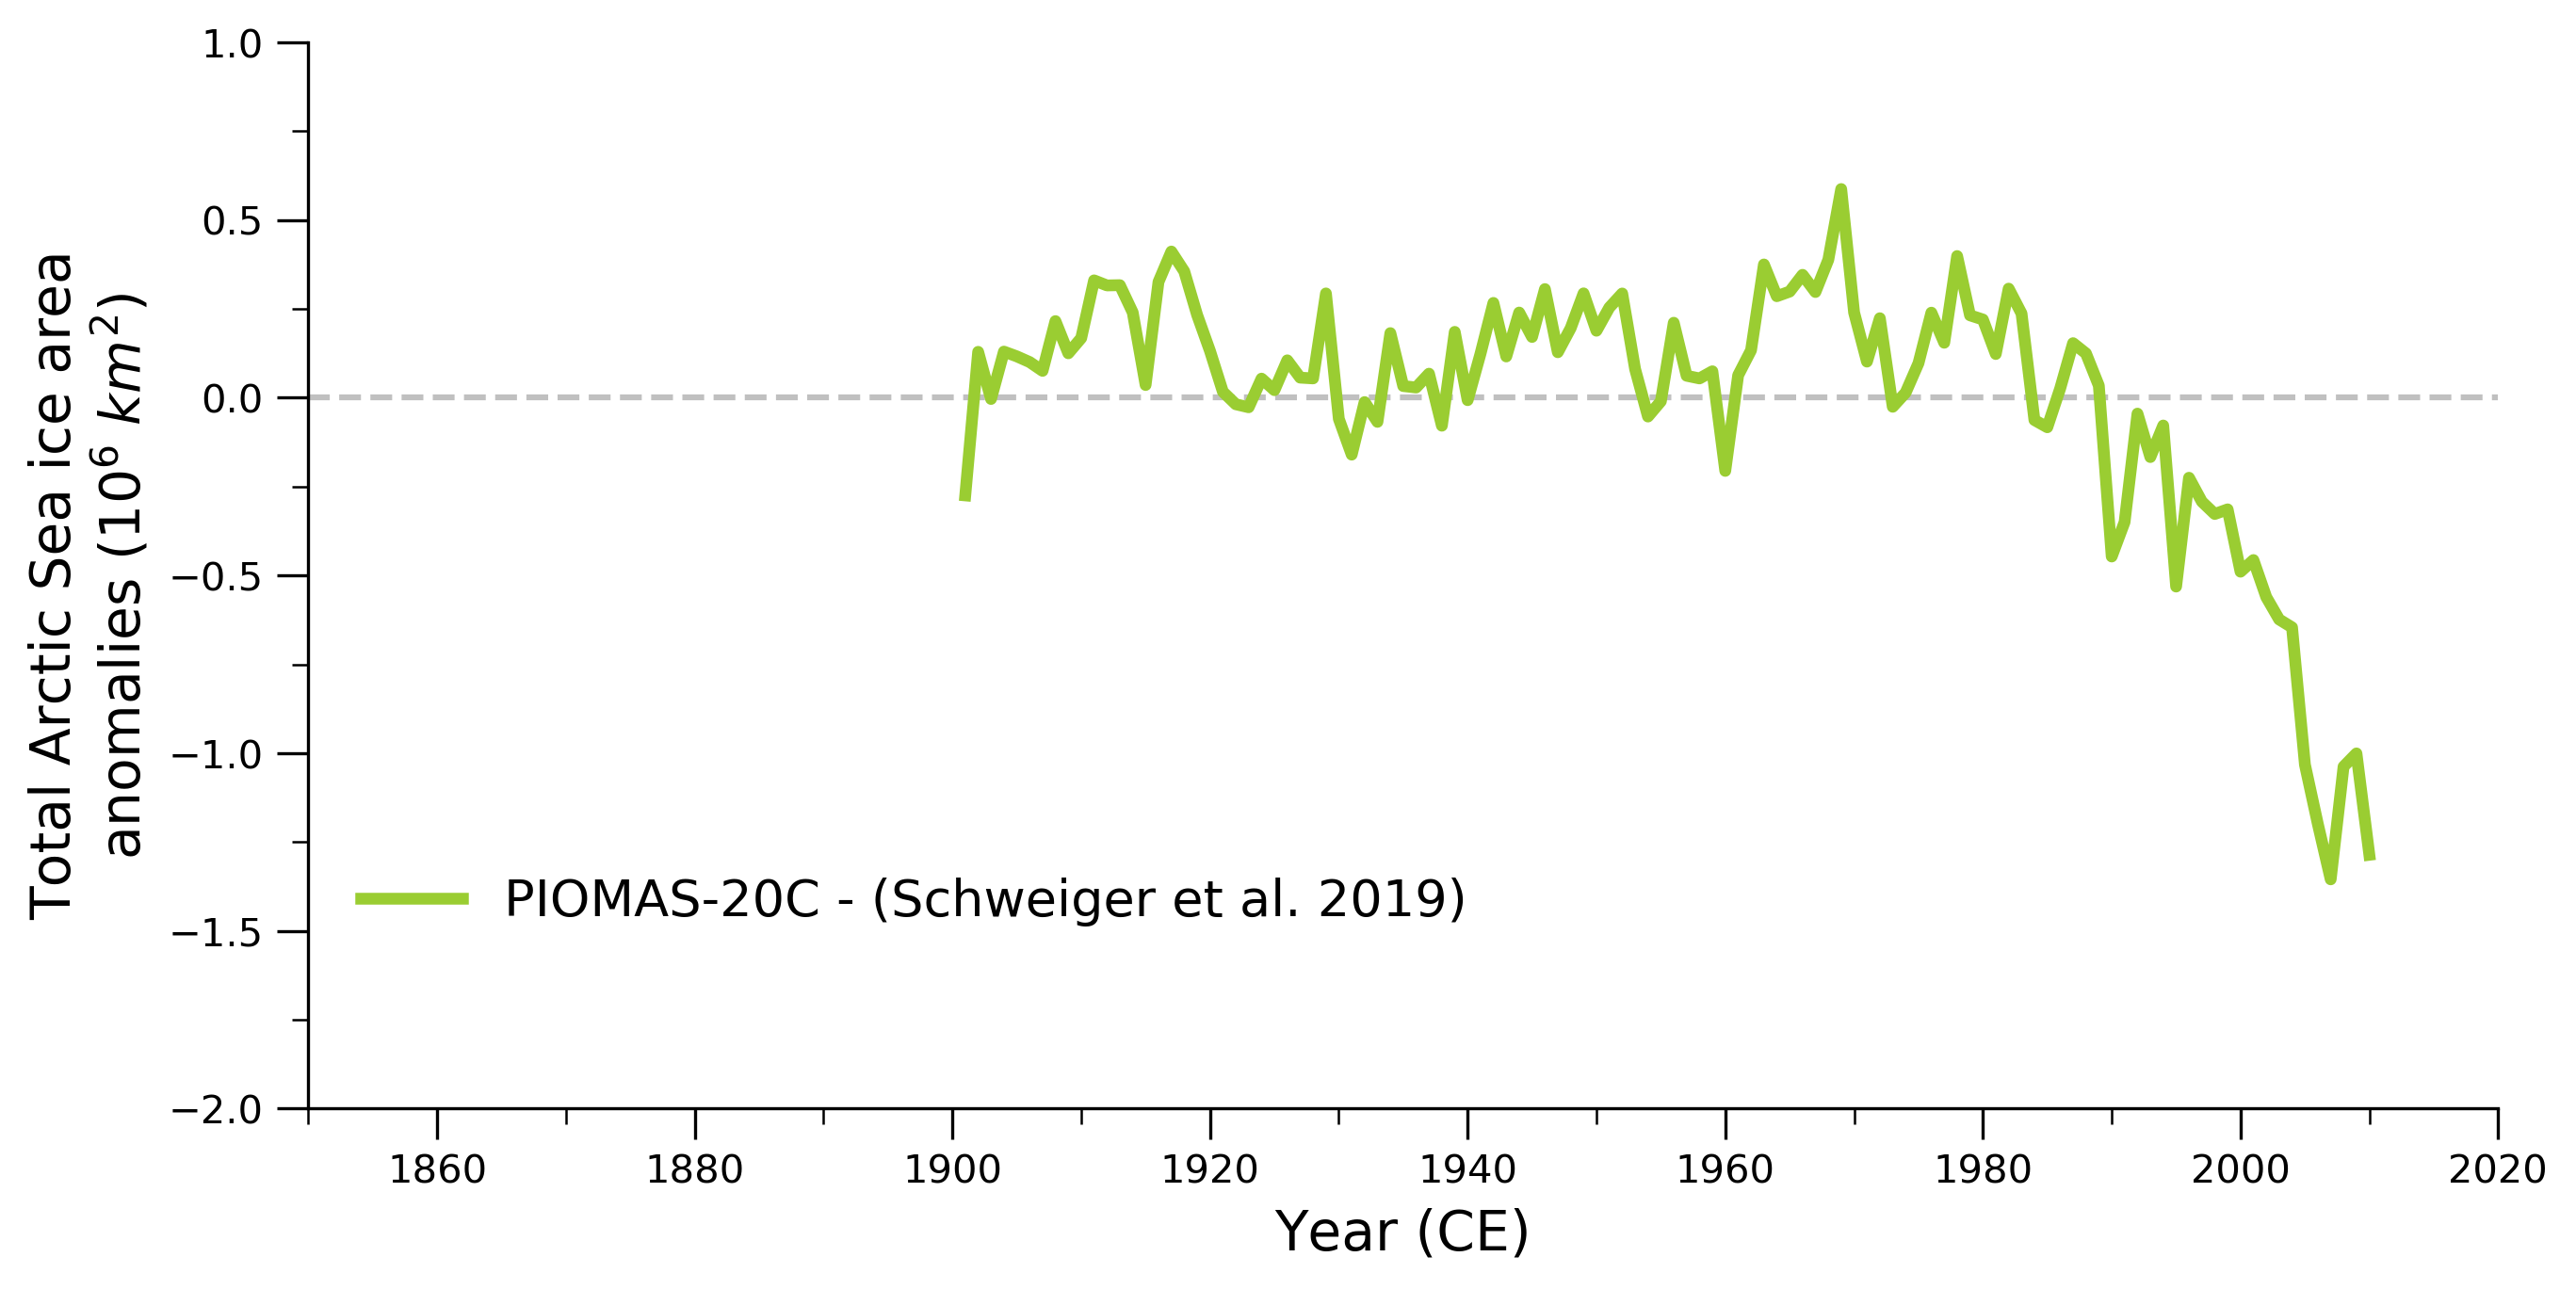

In [334]:
fig,ax = plt.subplots(1,figsize=(10,5))
plt.axhline(0,linestyle='--',color='silver')

#plt.plot(walsh_years,walsh_sia_noclimo_annual_anom, color='sienna', linewidth=1)
# plt.plot(walsh_time_annual, walsh_sia_annual_anom*1e-6, color='sienna', linewidth=2,
#          label='Reconstruction - (Walsh et al. 2019)' )
plt.plot(np.arange(1901,2011,1),piomas_sia_annual_anom*1e-6, color='yellowgreen', linewidth=3,
         label= 'PIOMAS-20C - (Schweiger et al. 2019)')

plt.xlim(1850,2020)
plt.ylim(-2,1.0)

plt.ylabel('Total Arctic Sea ice area \nanomalies (10$^{6}$ $km^2$)',fontsize=14)
plt.xlabel('Year (CE)',fontsize=14)

ax.legend(bbox_to_anchor=[0.55,0.26],fontsize=13, frameon=False)
# plt.text(1853,-1.9,'(PIOMAS20C,Walsh):  R$^2$ = '+str(np.round(corr_walsh_piomas_an**2,2))+
#          ', CE = '+str(np.round(ce_walsh_piomas_an,2)), fontsize=13)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=4)

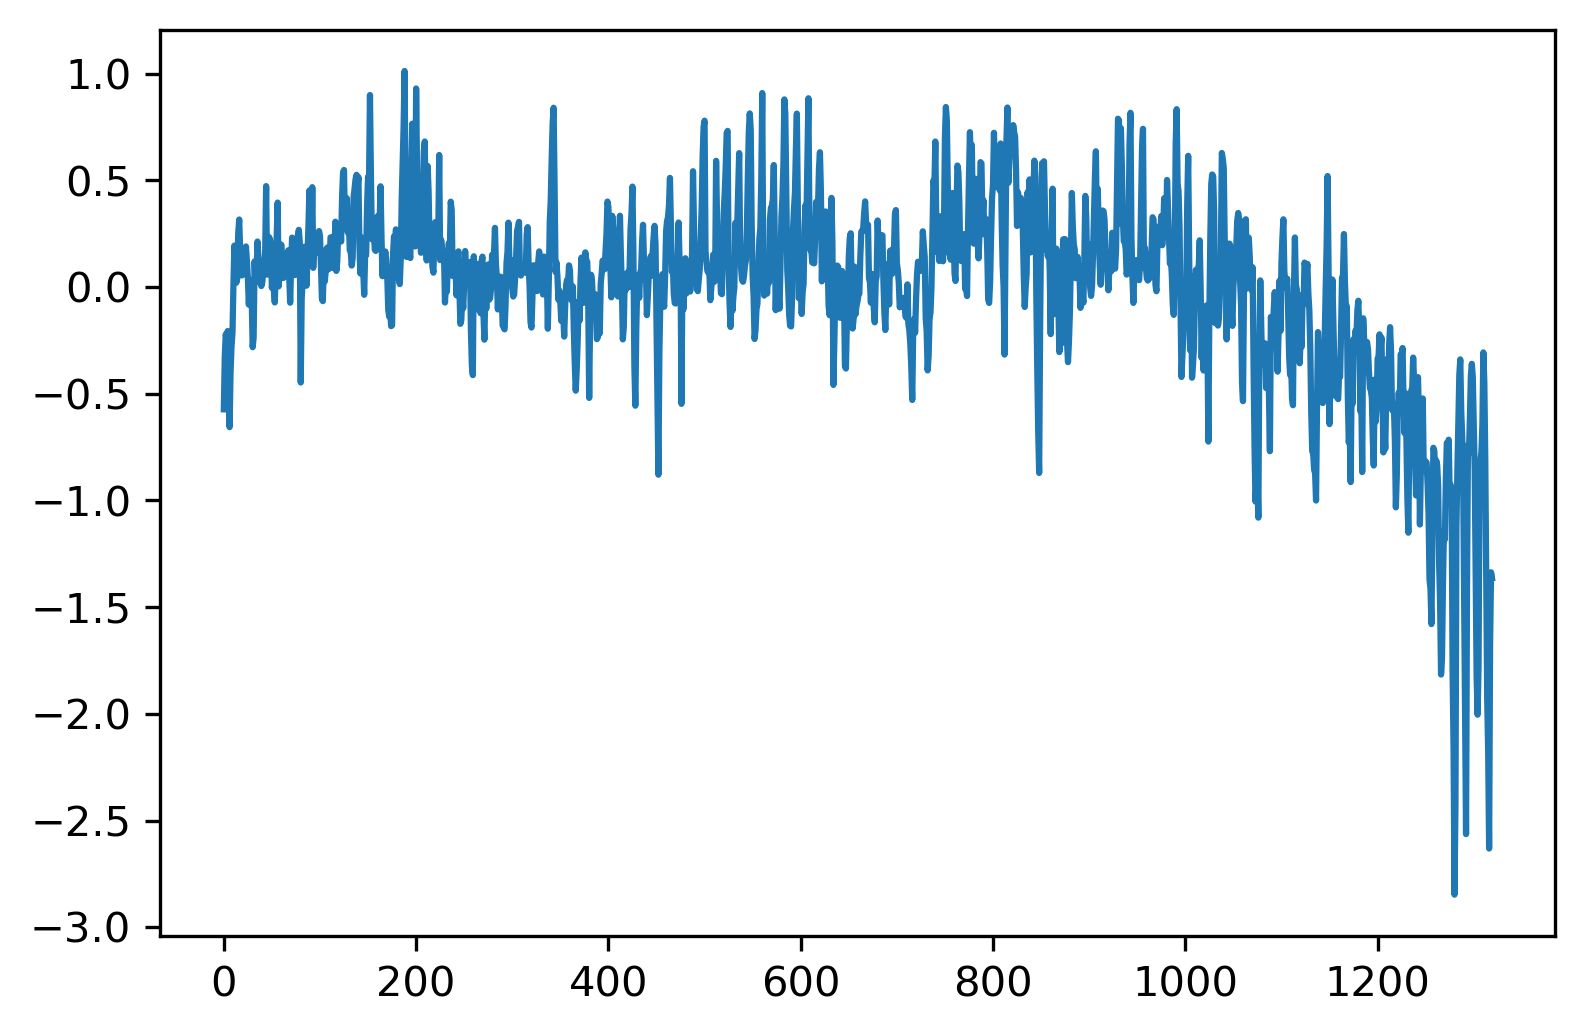

In [228]:
plt.plot(piomas_sia_anom*1e-6)